In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
#from tqdm.notebook import tqdm

sns.set_theme(style="whitegrid")

In [4]:
raw = pd.read_csv("train_data.csv")

In [5]:
raw.time = pd.to_datetime(raw.time)
raw.time = pd.Series([time + pd.DateOffset(days=day) for time, day in zip(raw.time, raw.day)])

In [6]:
raw = pd.DataFrame(data   =raw.to_numpy(), 
                   index  =raw.time, 
                   columns=raw.columns).drop(columns=['time', 'day'], axis=1)

In [7]:
symbols = np.sort(raw.symbol.unique())

In [118]:
stocks = {symbol : raw[raw.symbol == symbol].drop("symbol", axis=1).astype('float') for symbol in symbols}

In [119]:
for symbol, df in stocks.items():
    stocks[symbol] = df.resample('1D').bfill()

In [120]:
stocks["A"].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 87 entries, 2021-08-22 to 2021-11-16
Freq: D
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   open     87 non-null     float64
 1   high     87 non-null     float64
 2   low      87 non-null     float64
 3   close    87 non-null     float64
 4   average  87 non-null     float64
dtypes: float64(5)
memory usage: 4.1 KB


## Analyze dataset

In [121]:
stocks_open_normalized_data = np.zeros((87,10))
for i, symbol in enumerate(symbols):
    stocks_open_normalized_data[:, i] = stocks[symbol].open/stocks[symbol].open.iloc[0]
    
stocks_open_normalized = pd.DataFrame(data=stocks_open_normalized_data,
                                       columns=symbols,
                                       index=stocks["A"].index)

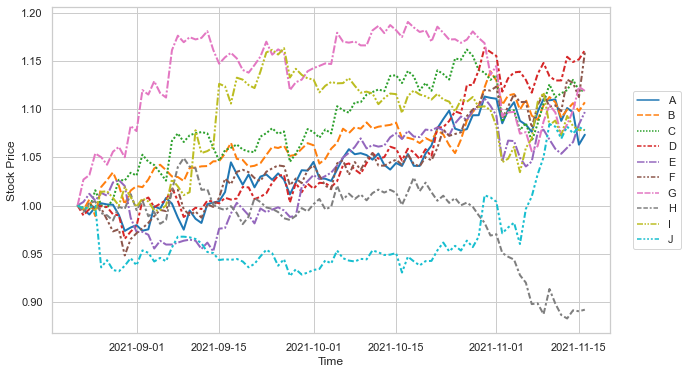

In [122]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=stocks_open_normalized, palette="tab10", linewidth=2)
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0);

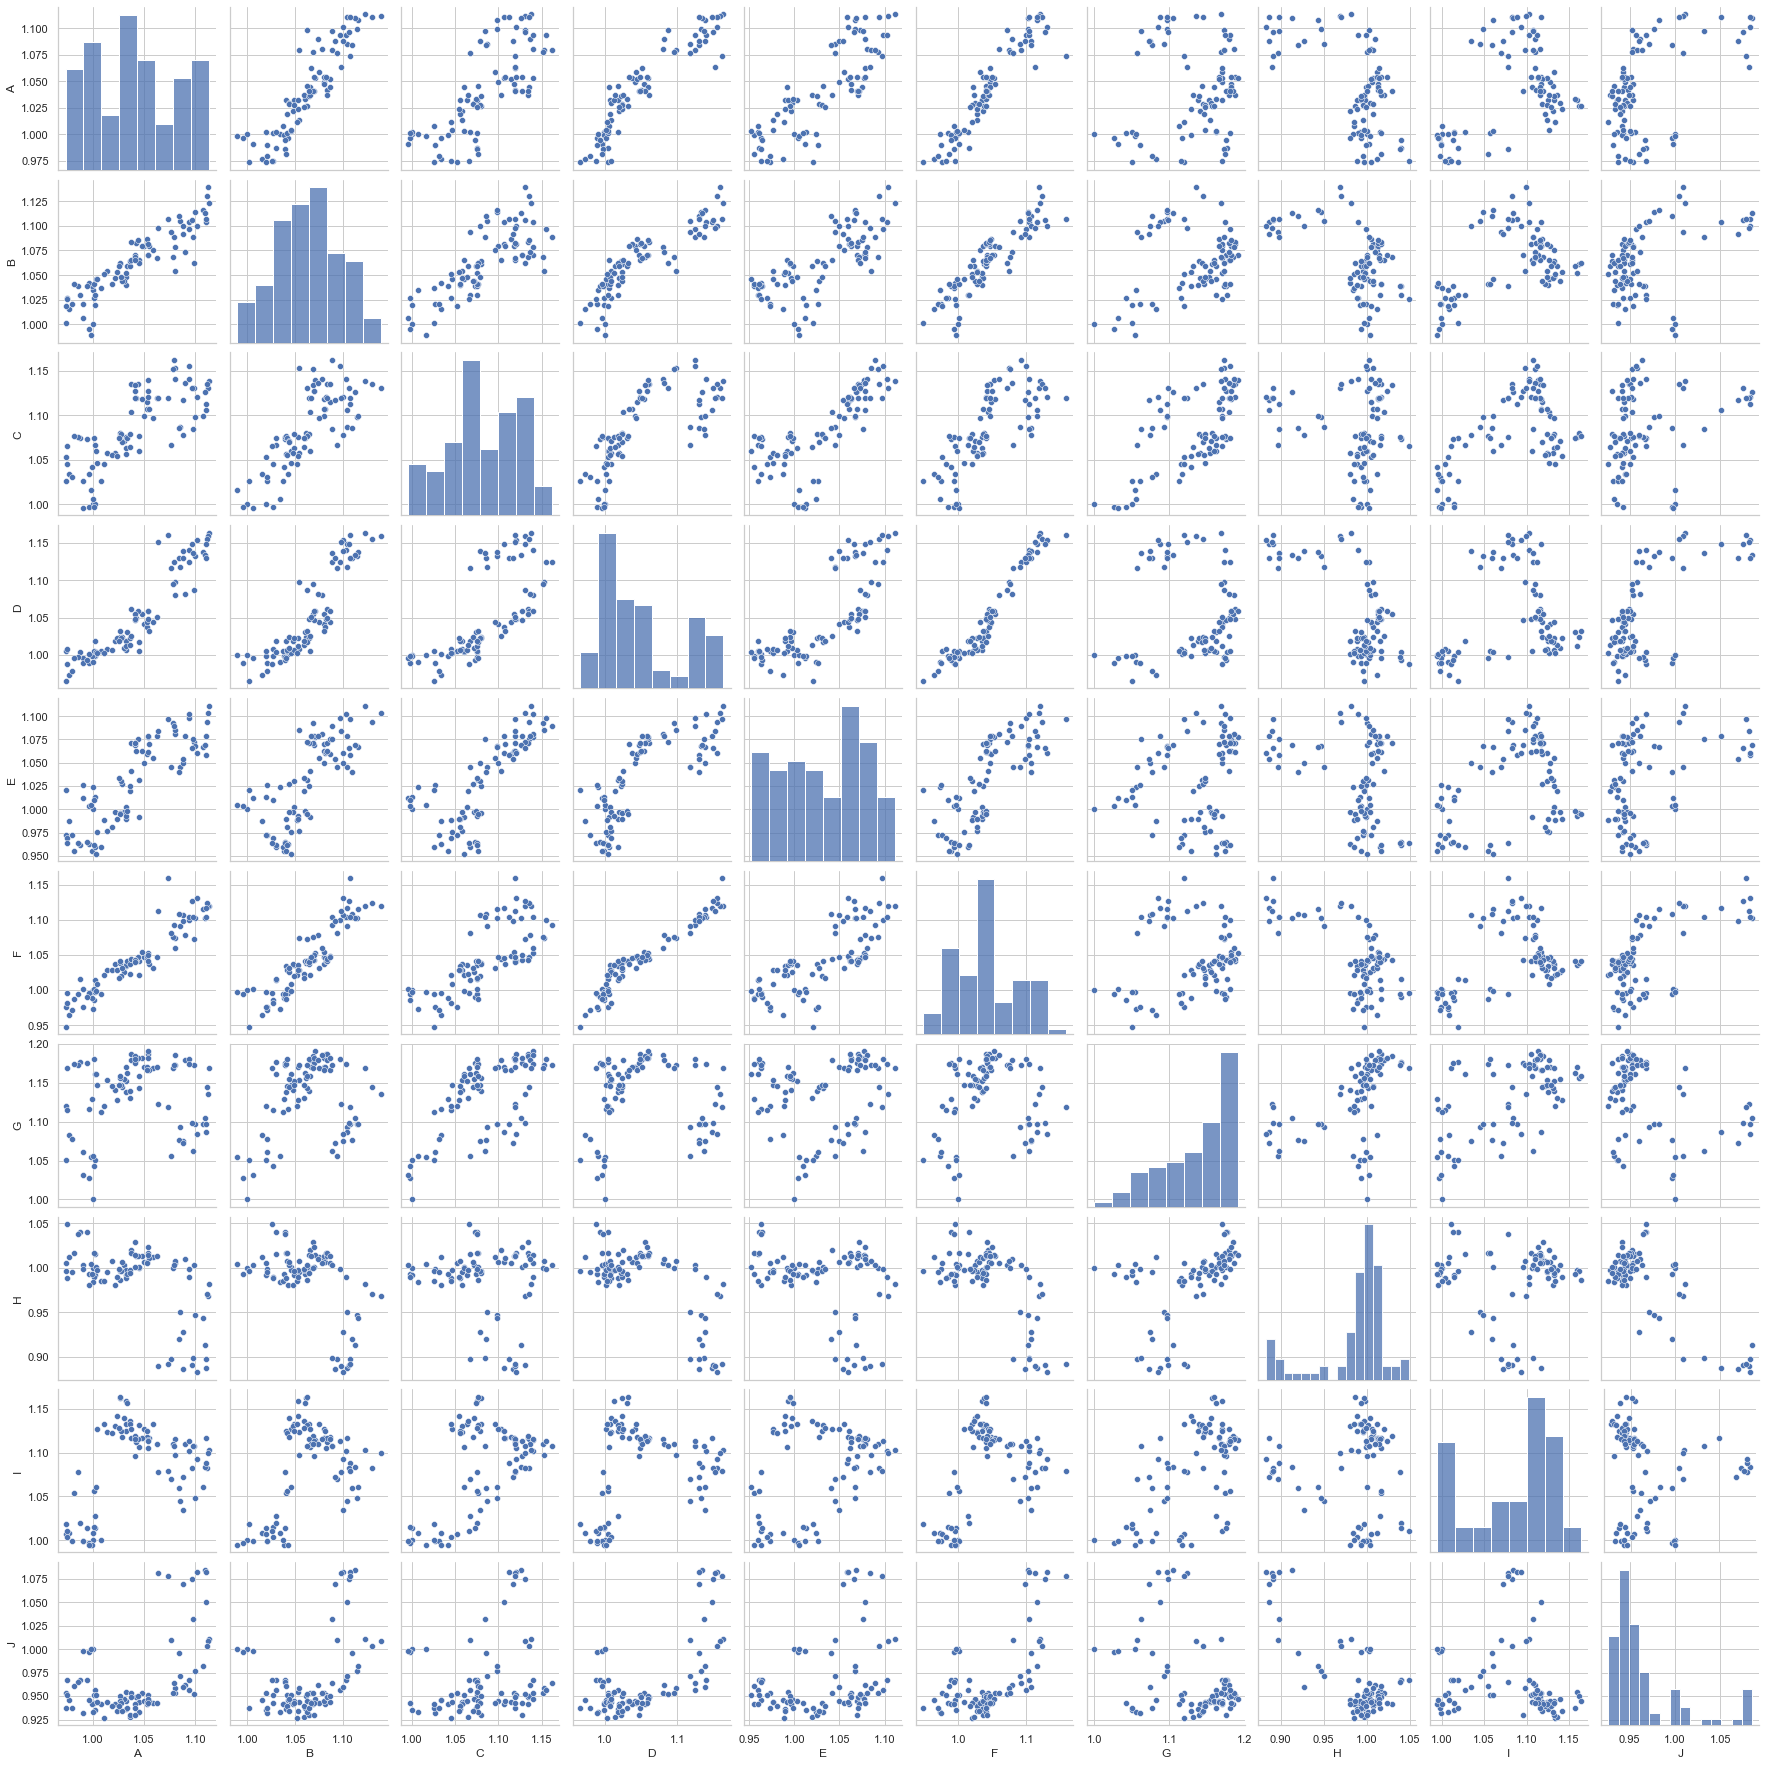

In [123]:
sns.pairplot(stocks_open_normalized)
plt.gca().set_aspect('equal')

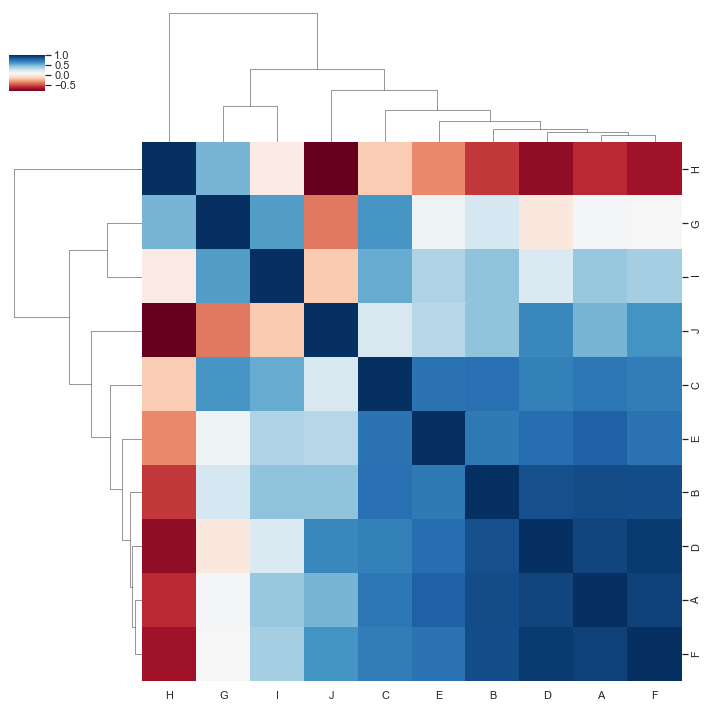

In [399]:
sns.clustermap(stocks_open_normalized.corr(), cmap="RdBu")
plt.gca().set_aspect('equal')

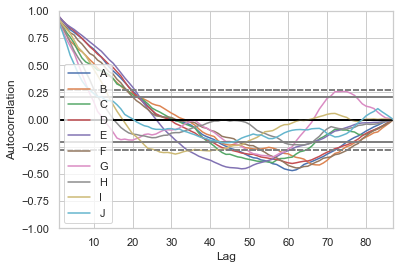

In [125]:
for symbol in symbols:
    pd.plotting.autocorrelation_plot(stocks[symbol].open, label=symbol)

## Featurize dataset using traditional stock market indicators

In [126]:
# we are predicting open prices, so let's drop everything else

stocks["A"] = stocks["A"].drop(["high", "low", "close", "average"], axis=1)

In [127]:
# simple moving average
# need source for which sma to use

stocks["A"]["sma5"]  = stocks["A"].open.rolling(5).mean().shift(1)
stocks["A"]["sma10"] = stocks["A"].open.rolling(10).mean().shift(1)
stocks["A"]["sma20"] = stocks["A"].open.rolling(20).mean().shift(1)

In [128]:
# exponential moving average
# link says ema8 and ema20 are common

stocks["A"]["ema8"]  = stocks["A"].open.ewm(8).mean().shift(1)
stocks["A"]["ema20"] = stocks["A"].open.ewm(20).mean().shift(1)

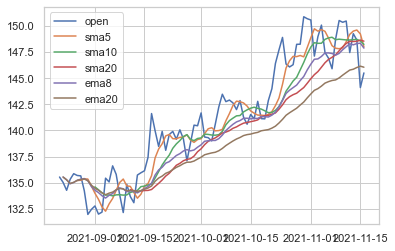

In [129]:
for col in stocks["A"]:
    plt.plot(stocks["A"][col], label=col)
plt.legend()

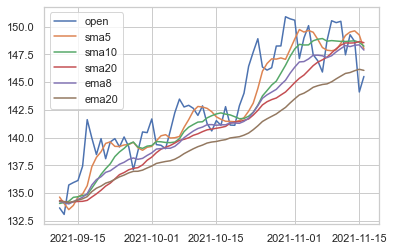

In [130]:
# truncate dataset for SMA/EMA min days

stocks["A"] = stocks["A"][20:] 

for col in stocks["A"]:
    plt.plot(stocks["A"][col], label=col)
plt.legend()

In [131]:
# set next day prediction and drop last item
stocks["A"]["nextOpen"] = stocks["A"].open.shift(-1).astype('float')
stocks["A"] = stocks["A"][:-1]

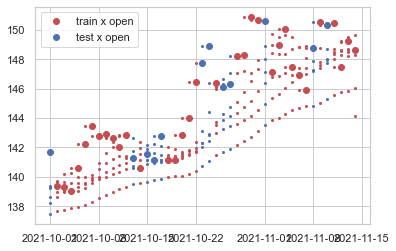

In [99]:
# plt.plot(train_df.open, 'ro', label="train x open")
# plt.plot(train_df.drop('open', axis=1), 'ro', markersize=2)
# plt.plot(test_df.open,  'bo', label="test x open")
# plt.plot(test_df.drop('open', axis=1), 'bo', markersize=2)
# plt.legend()

# ## want instead a train dataset that has all features for some t0-tn
# ## then train dataset labels are 9 days tn-tn+9 of only open prices

# ## LOO-CV for model? (use stocks A-G for train, H for test)


# ## or a train dataset that has all features and has label as open price of next day
# ## test dataset can be any subset of that entire train dataset

# # to predict using this, we'd just start from first day, predict, then compute new features, then predict again

In [132]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [133]:
stocks["A"].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 66 entries, 2021-09-11 to 2021-11-15
Freq: D
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   open      66 non-null     float64
 1   sma5      66 non-null     float64
 2   sma10     66 non-null     float64
 3   sma20     66 non-null     float64
 4   ema8      66 non-null     float64
 5   ema20     66 non-null     float64
 6   nextOpen  66 non-null     float64
dtypes: float64(7)
memory usage: 4.1 KB


In [135]:
%%time

parameters = {
    'n_estimators': [10, 50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [2, 4, 6, 8],
    'gamma': [0.01, 0.02, 0.05, 0.1],
    'random_state': [0]
}

model = xgb.XGBRegressor(objective='reg:squarederror')
clf   = GridSearchCV(model, parameters)

clf.fit(stocks["A"].drop('nextOpen', axis=1), stocks["A"].nextOpen)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'gamma': 0.02, 'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 200, 'random_state': 0}
Best validation score = -0.021746793138647157
CPU times: user 3min 32s, sys: 15.1 s, total: 3min 47s
Wall time: 1min 36s


In [136]:
# do train/test split
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(stocks["A"], train_size=0.75)

train_df = train_df.sort_index()
test_df  = test_df.sort_index()

y_train = train_df.open
X_train = train_df.drop('nextOpen', 1)

y_test  = test_df.open
X_test  = test_df.drop('nextOpen', 1)

X_train.info()

In [139]:
model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.02, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

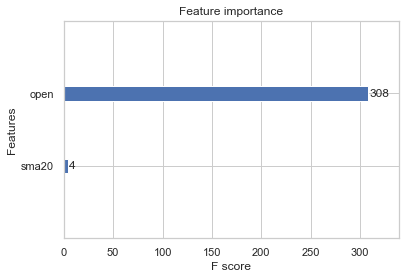

In [140]:
xgb.plot_importance(model);

In [141]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

y_true = [133.67 140.06 140.45 139.   142.76]
y_pred = [133.24405 139.96742 140.50679 139.16461 142.77847]


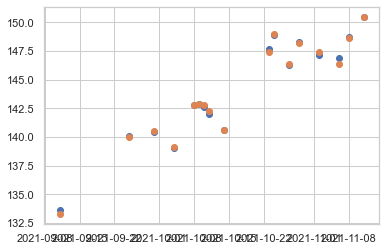

In [144]:
#plt.plot(train_df.open)
plt.scatter(X_test.index, y_test)
plt.scatter(X_test.index, y_pred)

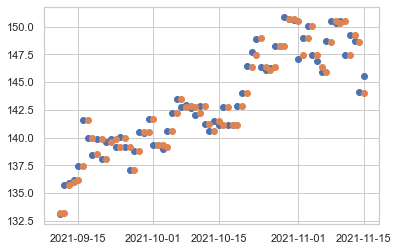

In [148]:
plt.scatter(stocks["A"].index, stocks["A"].nextOpen)
plt.scatter(stocks["A"].index, model.predict(stocks["A"].drop('nextOpen', axis=1)))

In [ ]:
plt.scatter(stocks["A"].index, stocks["A"].nextOpen-model.predict(stocks["A"].drop('nextOpen', axis=1)))

In [ ]:
for t in np.arange(1, 9):
    X_t = stocks["A"][:t].drop('nextOpen', axis=1)
    y_t1 = model.predict(X_t)
    y_hist.append(y_t1)
    # compute new features
    #iterate

## Same thing but now considering all stocks agnostically

In [213]:
stocks = {symbol : raw[raw.symbol == symbol].drop("symbol", axis=1).astype('float') for symbol in symbols}

for symbol in symbols:
    stocks[symbol] = stocks[symbol].resample('1D').bfill()
    stocks[symbol] = stocks[symbol].drop(["high", "low", "close", "average"], axis=1)
    stocks[symbol]["sma5"]  = stocks[symbol].open.rolling(5).mean().shift(1)
    stocks[symbol]["sma10"] = stocks[symbol].open.rolling(10).mean().shift(1)
    stocks[symbol]["sma20"] = stocks[symbol].open.rolling(20).mean().shift(1)
    stocks[symbol]["ema8"]  = stocks[symbol].open.ewm(8).mean().shift(1)
    stocks[symbol]["ema20"] = stocks[symbol].open.ewm(20).mean().shift(1)
    
    stocks[symbol] = stocks[symbol][20:]
    
    stocks[symbol]["nextOpen"] = stocks[symbol].open.shift(-1).astype('float')
    stocks[symbol] = stocks[symbol][:-1]

In [154]:
stocks["B"]

,open,sma5,sma10,sma20,ema8,ema20,nextOpen
time,,,,,,,
2021-09-11,105.73,104.996,104.856,103.8390,104.499726,104.145663,105.86
2021-09-12,105.86,105.050,105.051,104.0395,104.649006,104.263350,105.89
2021-09-13,105.89,105.264,105.271,104.2695,104.794460,104.378873,106.39
2021-09-14,106.39,105.496,105.413,104.4460,104.924872,104.485568,106.41
2021-09-15,106.41,105.912,105.488,104.7355,105.097908,104.617012,107.21
...,...,...,...,...,...,...,...
2021-11-11,112.64,112.078,112.640,111.7015,111.938926,110.605451,111.01
2021-11-12,111.01,112.026,112.410,111.8505,112.016828,110.704141,111.85
2021-11-13,111.85,111.984,112.276,111.9395,111.904952,110.718964,112.54


In [156]:
# concatenate all stocks into one df
all_stocks = pd.concat([stocks[symbol] for symbol in symbols])
all_stocks

,open,sma5,sma10,sma20,ema8,ema20,nextOpen
time,,,,,,,
2021-09-11,133.67,134.644,134.066,134.3320,134.218107,134.262165,133.08
2021-09-12,133.08,134.056,134.156,134.2385,134.151600,134.218177,135.73
2021-09-13,135.73,133.512,134.265,134.1410,134.022890,134.135827,135.95
2021-09-14,135.95,133.892,134.620,134.2140,134.226103,134.248386,136.14
2021-09-15,136.14,134.654,134.672,134.2455,134.429701,134.365831,137.43
...,...,...,...,...,...,...,...
2021-11-11,191.34,182.960,178.032,174.6535,177.050423,172.766458,189.12
2021-11-12,189.12,185.986,179.413,175.7910,178.638255,173.667401,191.36
2021-11-13,191.36,188.112,181.151,176.7455,179.802960,174.416292,190.08


In [ ]:
# could add all stocks in columns and try to predict vector of all nextOpens

# could add all stocks in columns and try to predict vector of all nextOpen for a 
#   single stock only and then make 10 models

In [157]:
%%time

parameters = {
    'n_estimators': [10, 50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [2, 4, 6, 8],
    'gamma': [0.01, 0.02, 0.05, 0.1],
    'random_state': [0]
}

model = xgb.XGBRegressor(objective='reg:squarederror')
clf   = GridSearchCV(model, parameters)

clf.fit(all_stocks.drop('nextOpen', axis=1), all_stocks.nextOpen)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'gamma': 0.01, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'random_state': 0}
Best validation score = 0.8640900510832459
CPU times: user 7min 28s, sys: 24.8 s, total: 7min 52s
Wall time: 3min 24s


In [158]:
train_df, test_df = train_test_split(all_stocks, train_size=0.75)

train_df = train_df.sort_index()
test_df  = test_df.sort_index()

y_train = train_df.open
X_train = train_df.drop('nextOpen', 1)

y_test  = test_df.open
X_test  = test_df.drop('nextOpen', 1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 495 entries, 2021-09-11 to 2021-11-15
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    495 non-null    float64
 1   sma5    495 non-null    float64
 2   sma10   495 non-null    float64
 3   sma20   495 non-null    float64
 4   ema8    495 non-null    float64
 5   ema20   495 non-null    float64
dtypes: float64(6)
memory usage: 27.1 KB


In [159]:
model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.01, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

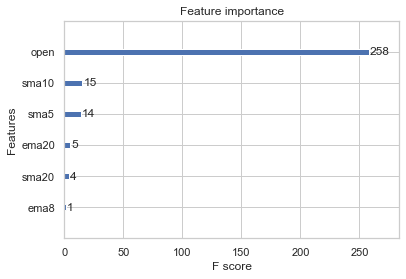

In [160]:
xgb.plot_importance(model);

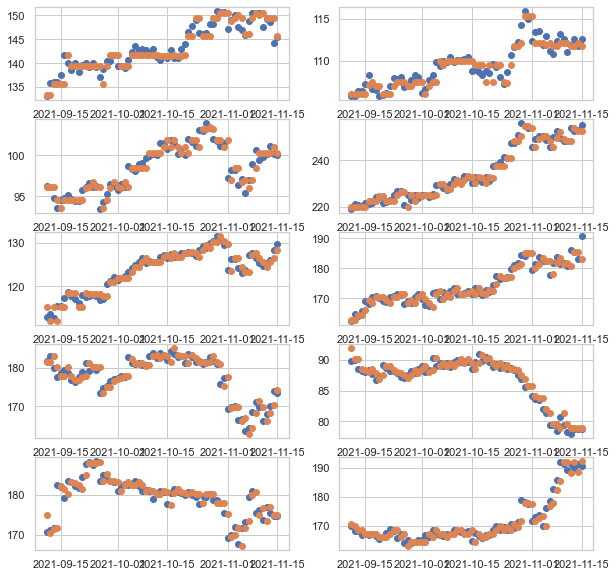

In [169]:
fig, axs = plt.subplots(5, 2, figsize=(10,10))
axs = axs.flatten()

for i, symbol in enumerate(symbols):
    axs[i].scatter(stocks[symbol].index, stocks[symbol].nextOpen)
    axs[i].scatter(stocks[symbol].index, model.predict(stocks[symbol].drop('nextOpen', axis=1)))

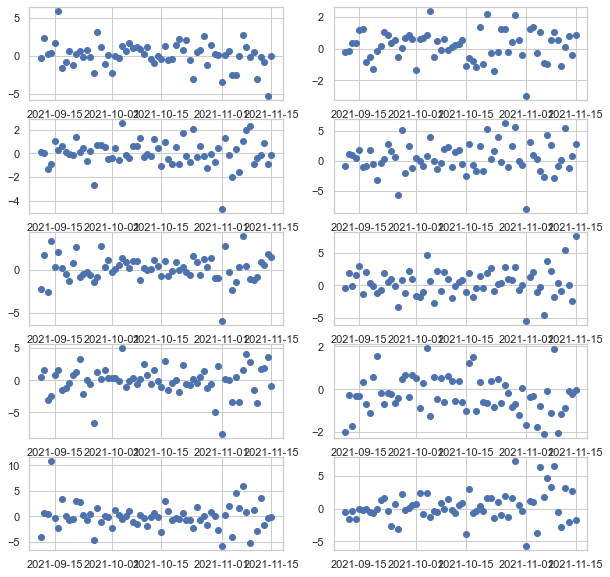

In [171]:
fig, axs = plt.subplots(5, 2, figsize=(10,10))
axs = axs.flatten()

for i, symbol in enumerate(symbols):
    axs[i].scatter(stocks[symbol].index, 
                   stocks[symbol].nextOpen-model.predict(stocks[symbol].drop('nextOpen', axis=1)))

In [ ]:
# one-hot encode the stock symbols

# one-hot encode stock symbols by cluster from correlation/clustermap

# predict A's open price from features of A and other stocks

In [257]:
import copy

stocks_pred = copy.deepcopy(stocks)
pred_days = 10

for i, day in enumerate(range(pred_days)):
    for j, symbol in enumerate(symbols):
        
        new_df = pd.DataFrame([[model.predict(stocks_pred[symbol].drop('nextOpen', axis=1))[-1], 
                                np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN]], 
                              columns=stocks_pred[symbol].columns,
                              index=stocks_pred[symbol].index[-1:]+pd.DateOffset(days=1))
        
        stocks_pred[symbol] = stocks_pred[symbol].append(new_df)

        stocks_pred[symbol].iloc[-1, 1:-1] = [stocks_pred[symbol].open.rolling(5).mean()[-1],
                                              stocks_pred[symbol].open.rolling(10).mean()[-1],
                                              stocks_pred[symbol].open.rolling(20).mean()[-1],
                                              stocks_pred[symbol].open.ewm(8).mean()[-1],
                                              stocks_pred[symbol].open.ewm(20).mean()[-1]]

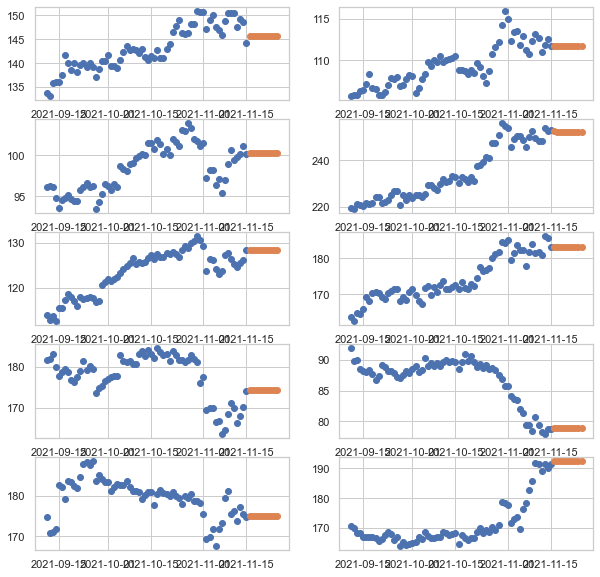

In [258]:
fig, axs = plt.subplots(5, 2, figsize=(10,10))
axs = axs.flatten()

for i, symbol in enumerate(symbols):
    axs[i].scatter(stocks_pred[symbol].index[:-pred_days], stocks_pred[symbol].open[:-pred_days])
    axs[i].scatter(stocks_pred[symbol].index[-pred_days:], stocks_pred[symbol].open[-pred_days:])

In [278]:
# make CSV
import csv

f = open('preds.csv', 'w')
writer = csv.writer(f)
writer.writerow(["id" , "open"])

stocks_pred_out = {symbol : stocks_pred[symbol].open.iloc[-pred_days:] for symbol in symbols}
# print(stocks_pred_out)

for symbol in symbols:
    # day is int 0-8
    # time is HH:MM:SS
    for i, index in enumerate(stocks_pred_out[symbol].index[:-1]):
        date_range = pd.date_range(start=stocks_pred_out[symbol].index[i] +
                                         pd.DateOffset(hours=6, minutes=0, seconds=0), 
                                   end=stocks_pred_out[symbol].index[i] + 
                                         pd.DateOffset(hours=12, minutes=59, seconds=55),
                                   freq='5S')
        p0 = stocks_pred_out[symbol].iloc[i]
        pf = stocks_pred_out[symbol].iloc[i+1]
        n = len(date_range)
        df = pd.DataFrame(data=[p0 + i/(n+1) * (pf - p0) for i in range(n)],
                         index=date_range)
        for index, row in df.iterrows():
            writer.writerow([symbol + "-" + 
                             str(i) + "-" + 
                             ("%02d" % index.hour) + ":" + ("%02d" % index.minute) + ":" + ("%02d" % index.second), 
                             "%.3f" % row])
f.close()

## Now consider predicting each stock using all stock data

In [286]:
stocks = {symbol : raw[raw.symbol == symbol].drop("symbol", axis=1).astype('float') for symbol in symbols}

for symbol in symbols:
    stocks[symbol] = stocks[symbol].resample('1D').bfill()
    stocks[symbol] = stocks[symbol].drop(["high", "low", "close", "average"], axis=1)
    
    stocks[symbol][symbol + "_sma5"]  = stocks[symbol].open.rolling(5).mean().shift(1)
    stocks[symbol][symbol + "_sma10"] = stocks[symbol].open.rolling(10).mean().shift(1)
    stocks[symbol][symbol + "_sma20"] = stocks[symbol].open.rolling(20).mean().shift(1)
    stocks[symbol][symbol + "_ema8"]  = stocks[symbol].open.ewm(8).mean().shift(1)
    stocks[symbol][symbol + "_ema20"] = stocks[symbol].open.ewm(20).mean().shift(1)
    
    stocks[symbol] = stocks[symbol][20:]
    
    stocks[symbol][symbol + "_nextOpen"] = stocks[symbol].open.shift(-1).astype('float')
    
    stocks[symbol] = stocks[symbol].rename(columns={"open": symbol + "_open"})
    
    stocks[symbol] = stocks[symbol][:-1]

In [287]:
# concatenate all stocks into one df
all_stocks = pd.concat([stocks[symbol] for symbol in symbols], axis=1)
all_stocks

,A_open,A_sma5,A_sma10,A_sma20,A_ema8,A_ema20,A_nextOpen,B_open,B_sma5,B_sma10,...,I_ema8,I_ema20,I_nextOpen,J_open,J_sma5,J_sma10,J_sma20,J_ema8,J_ema20,J_nextOpen
time,,,,,,,,,,,,,,,,,,,,,
2021-09-11,133.67,134.644,134.066,134.3320,134.218107,134.262165,133.08,105.73,104.996,104.856,...,163.427762,163.206057,170.85,170.69,169.784,168.526,169.3315,168.977397,169.041560,169.91
2021-09-12,133.08,134.056,134.156,134.2385,134.151600,134.218177,135.73,105.86,105.050,105.051,...,164.794314,164.059107,171.18,169.91,170.604,169.011,169.0240,169.185203,169.164009,168.29
2021-09-13,135.73,133.512,134.265,134.1410,134.022890,134.135827,135.95,105.89,105.264,105.271,...,165.521667,164.550448,171.81,168.29,170.762,169.143,168.7060,169.272259,169.217984,168.11
2021-09-14,135.95,133.892,134.620,134.2140,134.226103,134.248386,136.14,106.39,105.496,105.413,...,166.195232,165.018537,182.51,168.11,170.198,169.157,168.2950,169.155331,169.152462,166.82
2021-09-15,136.14,134.654,134.672,134.2455,134.429701,134.365831,137.43,106.41,105.912,105.488,...,166.858354,165.487283,182.09,166.82,169.598,169.313,167.8600,169.031875,169.080512,166.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-11,150.48,148.492,148.670,148.3290,148.021214,145.543427,147.46,112.64,112.078,112.640,...,176.000954,177.322579,173.81,191.34,182.960,178.032,174.6535,177.050423,172.766458,189.12
2021-11-12,147.46,149.204,148.660,148.5320,148.294430,145.782884,149.27,111.01,112.026,112.410,...,176.037517,177.274432,177.10,189.12,185.986,179.413,175.7910,178.638255,173.667401,191.36
2021-11-13,149.27,149.514,148.694,148.5195,148.201710,145.864164,148.66,111.85,111.984,112.276,...,175.790001,177.106533,175.37,191.36,188.112,181.151,176.7455,179.802960,174.416292,190.08


In [342]:
from tqdm import tqdm

cross_validate = True

train_df, test_df = train_test_split(all_stocks, train_size=0.80)

X_train = train_df.drop([symbol + "_nextOpen" for symbol in symbols], axis=1)
X_test  = test_df.drop( [symbol + "_nextOpen" for symbol in symbols], axis=1)

models = {}

for symbol in tqdm(symbols):
    
    ## set training and testing labels
    y_train = train_df[symbol + "_nextOpen"]   
    y_test  = test_df[ symbol + "_nextOpen"]

    ## model cross-validation
    baseline_params_ = {
        "n_estimators": 200,
        "learning_rate": 0.05,
        "max_depth": 4,
        "gamma": 0.01,
        "random_state": 0
    }
    
    parameters = {
        "n_estimators": [20, 50, 100, 200],
        "learning_rate": [0.05, 0.1, 0.2, 0.5],
        "max_depth": [4, 6, 8, 10],
        "gamma": [0.01, 0.02, 0.05, 0.1],
        "random_state": [0]
    }

    if cross_validate:
        model_obj = xgb.XGBRegressor(objective="reg:squarederror")
        
        search = GridSearchCV(model_obj, parameters)
        search.fit(all_stocks.drop([symbol + "_nextOpen" for symbol in symbols], axis=1), 
                   all_stocks[symbol + "_nextOpen"])

        print(search.best_params_)
    
        ## select optimal model
        models[symbol] = xgb.XGBRegressor(**clf.best_params_, objective="reg:squarederror")
        
    else:
        models[symbol] = xgb.XGBRegressor(**baseline_params_, objective="reg:squarederror")
        
    models[symbol].fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)



  0%|                                                    | 0/10 [00:00<?, ?it/s]

{'gamma': 0.05, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 0}




 10%|████▎                                      | 1/10 [03:35<32:15, 215.06s/it]

{'gamma': 0.02, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 50, 'random_state': 0}




 20%|████████▌                                  | 2/10 [06:42<27:34, 206.81s/it]

{'gamma': 0.01, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 50, 'random_state': 0}




 30%|████████████▉                              | 3/10 [10:07<24:02, 206.14s/it]

{'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200, 'random_state': 0}




 40%|█████████████████▏                         | 4/10 [14:09<21:41, 216.93s/it]

{'gamma': 0.01, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'random_state': 0}




 50%|█████████████████████▌                     | 5/10 [19:11<20:12, 242.54s/it]

{'gamma': 0.02, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 200, 'random_state': 0}




 60%|█████████████████████████▊                 | 6/10 [21:58<14:38, 219.74s/it]

{'gamma': 0.05, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'random_state': 0}




 70%|██████████████████████████████             | 7/10 [24:34<10:02, 200.80s/it]

{'gamma': 0.05, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 100, 'random_state': 0}




 80%|██████████████████████████████████▍        | 8/10 [26:50<06:02, 181.43s/it]

{'gamma': 0.05, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 50, 'random_state': 0}




 90%|██████████████████████████████████████▋    | 9/10 [29:10<02:48, 168.76s/it]

{'gamma': 0.02, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200, 'random_state': 0}




100%|██████████████████████████████████████████| 10/10 [31:30<00:00, 189.03s/it]


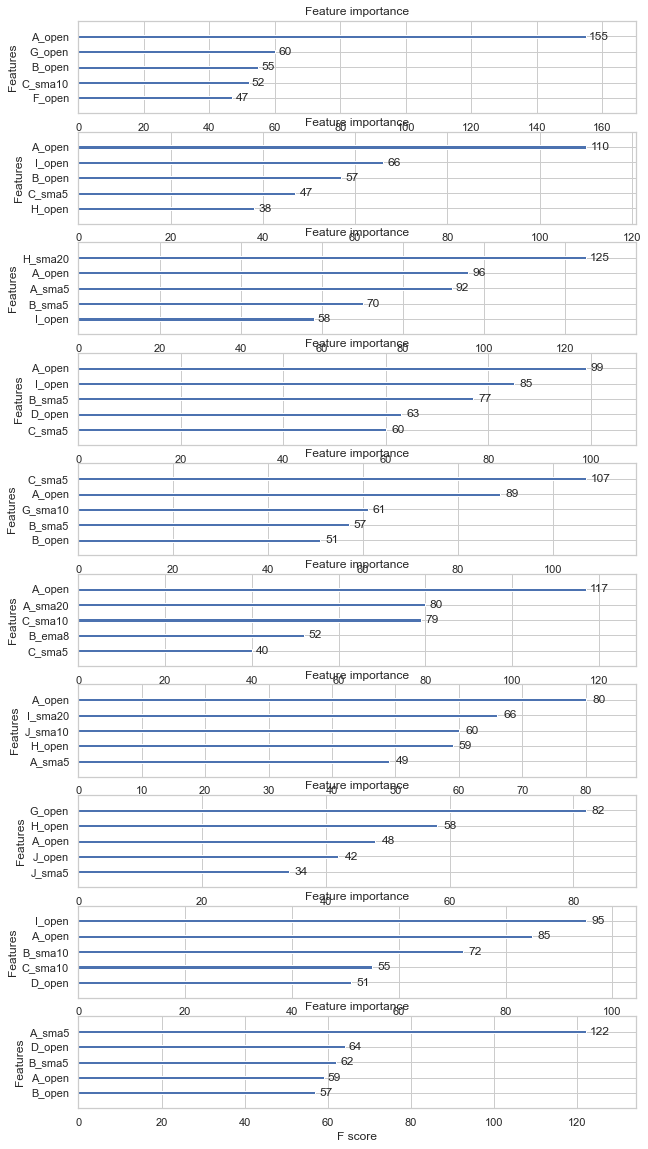

In [343]:
fig, axs = plt.subplots(10, 1, figsize=(10, 20))
axs = axs.flatten()

for i, model in enumerate(models.values()):
    xgb.plot_importance(model, ax=axs[i], max_num_features=5);

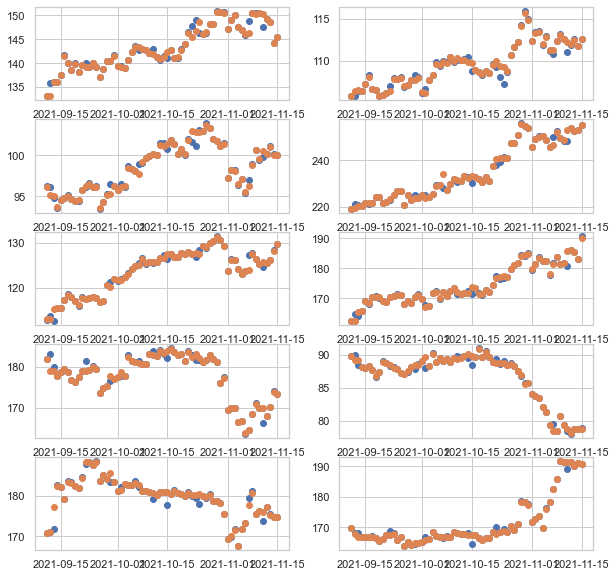

In [344]:
fig, axs = plt.subplots(5, 2, figsize=(10,10))
axs = axs.flatten()

for i, symbol in enumerate(symbols):
    axs[i].scatter(all_stocks.index, all_stocks[symbol + "_nextOpen"])
    axs[i].scatter(all_stocks.index, 
                   models[symbol].predict(all_stocks.drop([symbol + '_nextOpen' for symbol in symbols], axis=1)))

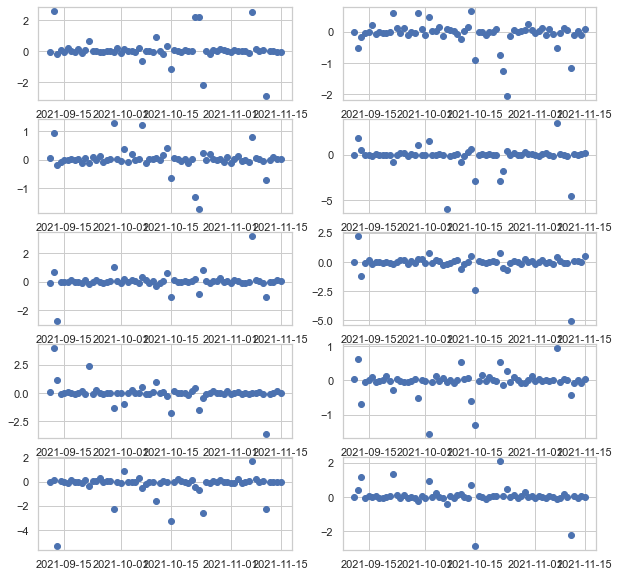

In [345]:
fig, axs = plt.subplots(5, 2, figsize=(10,10))
axs = axs.flatten()

for i, symbol in enumerate(symbols):
    axs[i].scatter(all_stocks.index, 
                   all_stocks[symbol + "_nextOpen"] - 
                   models[symbol].predict(all_stocks.drop([symbol + '_nextOpen' for symbol in symbols], axis=1)))

In [336]:
import copy

all_stocks_pred = copy.deepcopy(all_stocks)
pred_days = 10

for day in range(pred_days):
    
    new_df = pd.DataFrame(data   =np.repeat(np.NaN, 10*7).reshape(1, -1),
                          columns=all_stocks_pred.columns,
                          index  =all_stocks_pred.index[-1:]+pd.DateOffset(days=1))
    
    all_stocks_pred = all_stocks_pred.append(new_df)
    
    for symbol in symbols:
        
        pred = models[symbol].predict(all_stocks_pred.drop([symbol + "_nextOpen" for symbol in symbols], axis=1))[-1]
        
        all_stocks_pred[symbol + "_open"][-1] = pred
                
        all_stocks_pred[symbol + "_sma5"][-1]  = all_stocks_pred[symbol + "_open"].rolling(5).mean()[-1]
        all_stocks_pred[symbol + "_sma10"][-1] = all_stocks_pred[symbol + "_open"].rolling(10).mean()[-1]
        all_stocks_pred[symbol + "_sma20"][-1] = all_stocks_pred[symbol + "_open"].rolling(20).mean()[-1]
        all_stocks_pred[symbol + "_ema8"][-1]  = all_stocks_pred[symbol + "_open"].ewm(8).mean()[-1]
        all_stocks_pred[symbol + "_ema20"][-1] = all_stocks_pred[symbol + "_open"].ewm(20).mean()[-1]

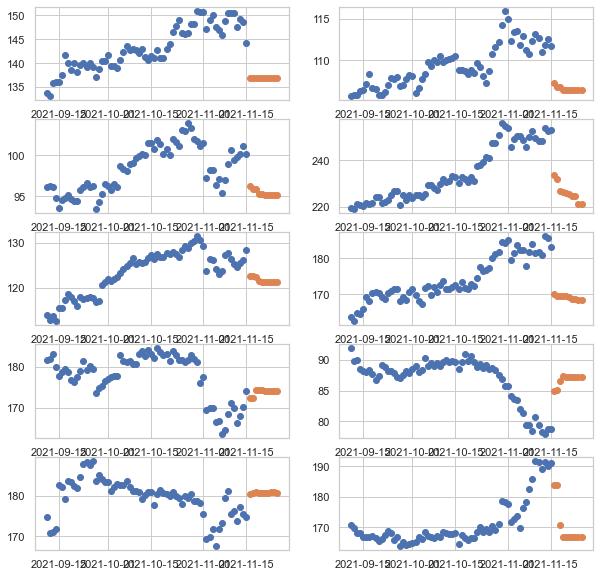

In [337]:
fig, axs = plt.subplots(5, 2, figsize=(10,10))
axs = axs.flatten()

for i, symbol in enumerate(symbols):
    axs[i].scatter(all_stocks_pred.index[:-pred_days], all_stocks_pred[symbol + "_open"][:-pred_days])
    axs[i].scatter(all_stocks_pred.index[-pred_days:], all_stocks_pred[symbol + "_open"][-pred_days:])

In [338]:
all_stocks_pred

,A_open,A_sma5,A_sma10,A_sma20,A_ema8,A_ema20,A_nextOpen,B_open,B_sma5,B_sma10,...,I_ema8,I_ema20,I_nextOpen,J_open,J_sma5,J_sma10,J_sma20,J_ema8,J_ema20,J_nextOpen
time,,,,,,,,,,,,,,,,,,,,,
2021-09-11,133.670000,134.644000,134.066000,134.332000,134.218107,134.262165,133.08,105.73000,104.996000,104.856000,...,163.427762,163.206057,170.85,170.690000,169.784000,168.526000,169.331500,168.977397,169.041560,169.91
2021-09-12,133.080000,134.056000,134.156000,134.238500,134.151600,134.218177,135.73,105.86000,105.050000,105.051000,...,164.794314,164.059107,171.18,169.910000,170.604000,169.011000,169.024000,169.185203,169.164009,168.29
2021-09-13,135.730000,133.512000,134.265000,134.141000,134.022890,134.135827,135.95,105.89000,105.264000,105.271000,...,165.521667,164.550448,171.81,168.290000,170.762000,169.143000,168.706000,169.272259,169.217984,168.11
2021-09-14,135.950000,133.892000,134.620000,134.214000,134.226103,134.248386,136.14,106.39000,105.496000,105.413000,...,166.195232,165.018537,182.51,168.110000,170.198000,169.157000,168.295000,169.155331,169.152462,166.82
2021-09-15,136.140000,134.654000,134.672000,134.245500,134.429701,134.365831,137.43,106.41000,105.912000,105.488000,...,166.858354,165.487283,182.09,166.820000,169.598000,169.313000,167.860000,169.031875,169.080512,166.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-21,136.949692,136.949692,141.119815,144.889908,142.345720,143.900846,NaN,106.45491,106.613608,108.745133,...,178.211844,178.139617,NaN,166.884247,171.013440,180.070720,179.741860,177.395370,175.767511,NaN
2021-11-22,136.949692,136.949692,140.068784,144.381392,141.746051,143.560167,NaN,106.45491,106.534259,108.289624,...,178.492774,178.267051,NaN,166.926483,167.642874,177.851368,179.501184,176.231946,175.334208,NaN
2021-11-23,136.949692,136.949692,138.836753,143.779877,141.213034,143.236634,NaN,106.45491,106.454910,107.750115,...,178.746406,178.389800,NaN,166.926483,166.883185,175.408017,179.207008,175.197836,174.922714,NaN


In [346]:
# save out these preds
# make CSV

f = open('preds.csv', 'w')
writer = csv.writer(f)
writer.writerow(["id" , "open"])

stocks_pred_out = {symbol : all_stocks_pred[symbol + "_open"].iloc[-pred_days:] for symbol in symbols}
# print(stocks_pred_out)

for symbol in symbols:
    # day is int 0-8
    # time is HH:MM:SS
    for i, index in enumerate(stocks_pred_out[symbol].index[:-1]):
        date_range = pd.date_range(start=stocks_pred_out[symbol].index[i] +
                                         pd.DateOffset(hours=6, minutes=0, seconds=0), 
                                   end=stocks_pred_out[symbol].index[i] + 
                                         pd.DateOffset(hours=12, minutes=59, seconds=55),
                                   freq='5S')
        p0 = stocks_pred_out[symbol].iloc[i]
        pf = stocks_pred_out[symbol].iloc[i+1]
        n = len(date_range)
        df = pd.DataFrame(data=[p0 + i/(n+1) * (pf - p0) for i in range(n)],
                         index=date_range)
        for index, row in df.iterrows():
            writer.writerow([symbol + "-" + 
                             str(i) + "-" + 
                             ("%02d" % index.hour) + ":" + ("%02d" % index.minute) + ":" + ("%02d" % index.second), 
                             "%.3f" % row])
f.close()

# do it again but using delta open instead of price itself

In [356]:


stocks = {symbol : raw[raw.symbol == symbol].drop("symbol", axis=1).astype('float') for symbol in symbols}

for symbol in symbols:
    stocks[symbol] = stocks[symbol].resample('1D').bfill()
    stocks[symbol] = stocks[symbol].drop(["high", "low", "close", "average"], axis=1)
    
    stocks[symbol][symbol + "_sma5"]  = stocks[symbol].open.rolling(5).mean().shift(1)
    stocks[symbol][symbol + "_sma10"] = stocks[symbol].open.rolling(10).mean().shift(1)
    stocks[symbol][symbol + "_sma20"] = stocks[symbol].open.rolling(20).mean().shift(1)
    stocks[symbol][symbol + "_ema8"]  = stocks[symbol].open.ewm(8).mean().shift(1)
    stocks[symbol][symbol + "_ema20"] = stocks[symbol].open.ewm(20).mean().shift(1)
    
    stocks[symbol] = stocks[symbol][20:]
    
    stocks[symbol][symbol + "_pct_chg"] = stocks[symbol].open.diff().shift(-1).astype('float') / \
                                       stocks[symbol].open.astype('float') + np.ones(len(stocks[symbol].open))
    
    stocks[symbol] = stocks[symbol].rename(columns={"open": symbol + "_open"})
    
    stocks[symbol] = stocks[symbol][:-1]
    
# concatenate all stocks into one df
all_stocks = pd.concat([stocks[symbol] for symbol in symbols], axis=1)
all_stocks

,A_open,A_sma5,A_sma10,A_sma20,A_ema8,A_ema20,A_pct_chg,B_open,B_sma5,B_sma10,...,I_ema8,I_ema20,I_pct_chg,J_open,J_sma5,J_sma10,J_sma20,J_ema8,J_ema20,J_pct_chg
time,,,,,,,,,,,,,,,,,,,,,
2021-09-11,133.67,134.644,134.066,134.3320,134.218107,134.262165,0.995586,105.73,104.996,104.856,...,163.427762,163.206057,0.978018,170.69,169.784,168.526,169.3315,168.977397,169.041560,0.995430
2021-09-12,133.08,134.056,134.156,134.2385,134.151600,134.218177,1.019913,105.86,105.050,105.051,...,164.794314,164.059107,1.001932,169.91,170.604,169.011,169.0240,169.185203,169.164009,0.990466
2021-09-13,135.73,133.512,134.265,134.1410,134.022890,134.135827,1.001621,105.89,105.264,105.271,...,165.521667,164.550448,1.003680,168.29,170.762,169.143,168.7060,169.272259,169.217984,0.998930
2021-09-14,135.95,133.892,134.620,134.2140,134.226103,134.248386,1.001398,106.39,105.496,105.413,...,166.195232,165.018537,1.062278,168.11,170.198,169.157,168.2950,169.155331,169.152462,0.992326
2021-09-15,136.14,134.654,134.672,134.2455,134.429701,134.365831,1.009476,106.41,105.912,105.488,...,166.858354,165.487283,0.997699,166.82,169.598,169.313,167.8600,169.031875,169.080512,1.000899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-11,150.48,148.492,148.670,148.3290,148.021214,145.543427,0.979931,112.64,112.078,112.640,...,176.000954,177.322579,0.985709,191.34,182.960,178.032,174.6535,177.050423,172.766458,0.988398
2021-11-12,147.46,149.204,148.660,148.5320,148.294430,145.782884,1.012275,111.01,112.026,112.410,...,176.037517,177.274432,1.018929,189.12,185.986,179.413,175.7910,178.638255,173.667401,1.011844
2021-11-13,149.27,149.514,148.694,148.5195,148.201710,145.864164,0.995913,111.85,111.984,112.276,...,175.790001,177.106533,0.990232,191.36,188.112,181.151,176.7455,179.802960,174.416292,0.993311


In [357]:
from tqdm import tqdm

cross_validate = False

train_df, test_df = train_test_split(all_stocks, train_size=0.80)

X_train = train_df.drop([symbol + "_pct_chg" for symbol in symbols], axis=1)
X_test  = test_df.drop( [symbol + "_pct_chg" for symbol in symbols], axis=1)

models = {}

for symbol in tqdm(symbols):
    
    ## set training and testing labels
    y_train = train_df[symbol + "_pct_chg"]   
    y_test  = test_df[ symbol + "_pct_chg"]

    ## model cross-validation
    baseline_params_ = {
        "n_estimators": 200,
        "learning_rate": 0.05,
        "max_depth": 4,
        "gamma": 0.01,
        "random_state": 0
    }
    
    parameters = {
        "n_estimators": [20, 50, 100, 200],
        "learning_rate": [0.05, 0.1, 0.2, 0.5],
        "max_depth": [4, 6, 8, 10],
        "gamma": [0.01, 0.02, 0.05, 0.1],
        "random_state": [0]
    }

    if cross_validate:
        model_obj = xgb.XGBRegressor(objective="reg:squarederror")
        
        search = GridSearchCV(model_obj, parameters)
        search.fit(all_stocks.drop([symbol + "_pct_chg" for symbol in symbols], axis=1), 
                   all_stocks[symbol + "_pct_chg"])

        print(search.best_params_)
    
        ## select optimal model
        models[symbol] = xgb.XGBRegressor(**clf.best_params_, objective="reg:squarederror")
        
    else:
        models[symbol] = xgb.XGBRegressor(**baseline_params_, objective="reg:squarederror")
        
    models[symbol].fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)



  0%|                                                    | 0/10 [00:00<?, ?it/s]

 10%|████▍                                       | 1/10 [00:00<00:05,  1.68it/s]

 20%|████████▊                                   | 2/10 [00:00<00:04,  1.89it/s]

 30%|█████████████▏                              | 3/10 [00:01<00:04,  1.48it/s]

 40%|█████████████████▌                          | 4/10 [00:02<00:03,  1.76it/s]

 50%|██████████████████████                      | 5/10 [00:02<00:02,  1.94it/s]

 60%|██████████████████████████▍                 | 6/10 [00:03<00:02,  1.81it/s]

 70%|██████████████████████████████▊             | 7/10 [00:04<00:02,  1.28it/s]

 80%|███████████████████████████████████▏        | 8/10 [00:05<00:01,  1.32it/s]

 90%|███████████████████████████████████████▌    | 9/10 [00:06<00:00,  1.16it/s]

100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.40it/s]


ValueError: Booster.get_score() results in empty.  This maybe caused by having all trees as decision dumps.

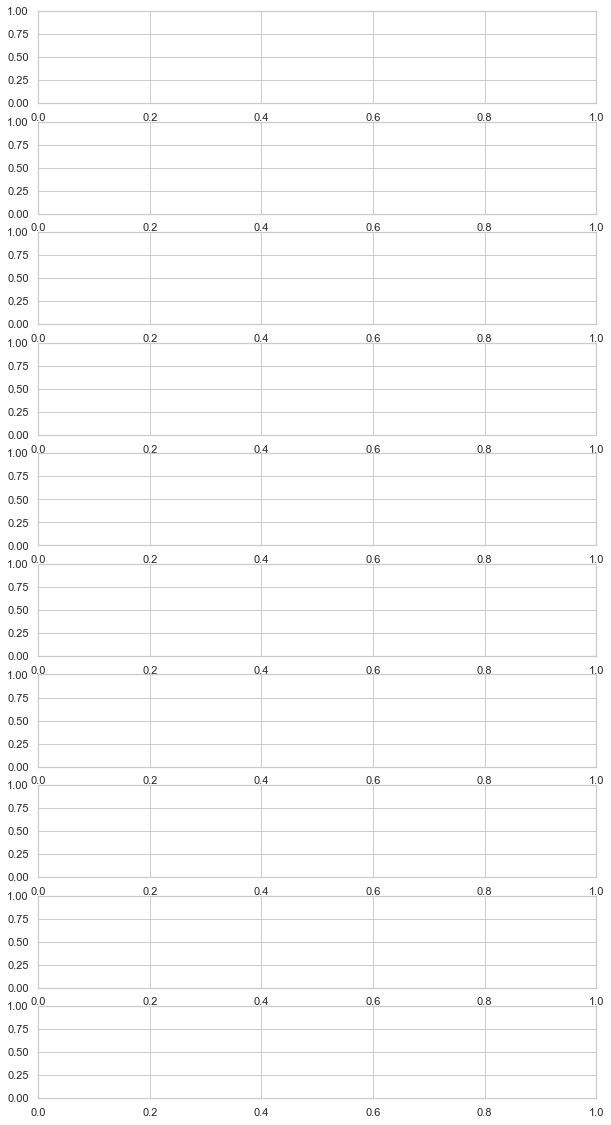

In [358]:
fig, axs = plt.subplots(10, 1, figsize=(10, 20))
axs = axs.flatten()

for i, model in enumerate(models.values()):
    xgb.plot_importance(model, ax=axs[i], max_num_features=5);

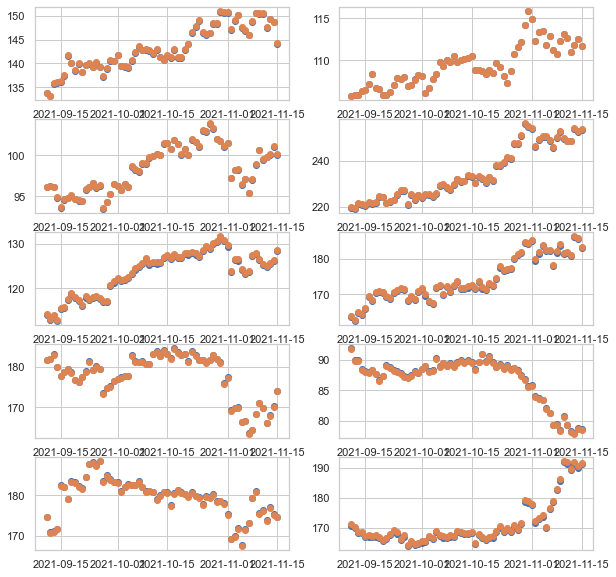

In [359]:
fig, axs = plt.subplots(5, 2, figsize=(10,10))
axs = axs.flatten()

for i, symbol in enumerate(symbols):
    axs[i].scatter(all_stocks.index, all_stocks[symbol + "_open"])
    axs[i].scatter(all_stocks.index, 
                   all_stocks[symbol + "_open"] * \
                   models[symbol].predict(all_stocks.drop([symbol + '_pct_chg' for symbol in symbols], axis=1)))

In [360]:
import copy

all_stocks_pred = copy.deepcopy(all_stocks)
pred_days = 10

for day in range(pred_days):
    
    new_df = pd.DataFrame(data   =np.repeat(np.NaN, 10*7).reshape(1, -1),
                          columns=all_stocks_pred.columns,
                          index  =all_stocks_pred.index[-1:]+pd.DateOffset(days=1))
    
    all_stocks_pred = all_stocks_pred.append(new_df)
    
    for symbol in symbols:
        
        pred_pct = models[symbol].predict(all_stocks_pred.drop([symbol + "_pct_chg" for symbol in symbols], axis=1))[-1]
        
        all_stocks_pred[symbol + "_open"][-1] = pred_pct * all_stocks_pred[symbol + "_open"][-2]
                
        all_stocks_pred[symbol + "_sma5"][-1]  = all_stocks_pred[symbol + "_open"].rolling(5).mean()[-1]
        all_stocks_pred[symbol + "_sma10"][-1] = all_stocks_pred[symbol + "_open"].rolling(10).mean()[-1]
        all_stocks_pred[symbol + "_sma20"][-1] = all_stocks_pred[symbol + "_open"].rolling(20).mean()[-1]
        all_stocks_pred[symbol + "_ema8"][-1]  = all_stocks_pred[symbol + "_open"].ewm(8).mean()[-1]
        all_stocks_pred[symbol + "_ema20"][-1] = all_stocks_pred[symbol + "_open"].ewm(20).mean()[-1]

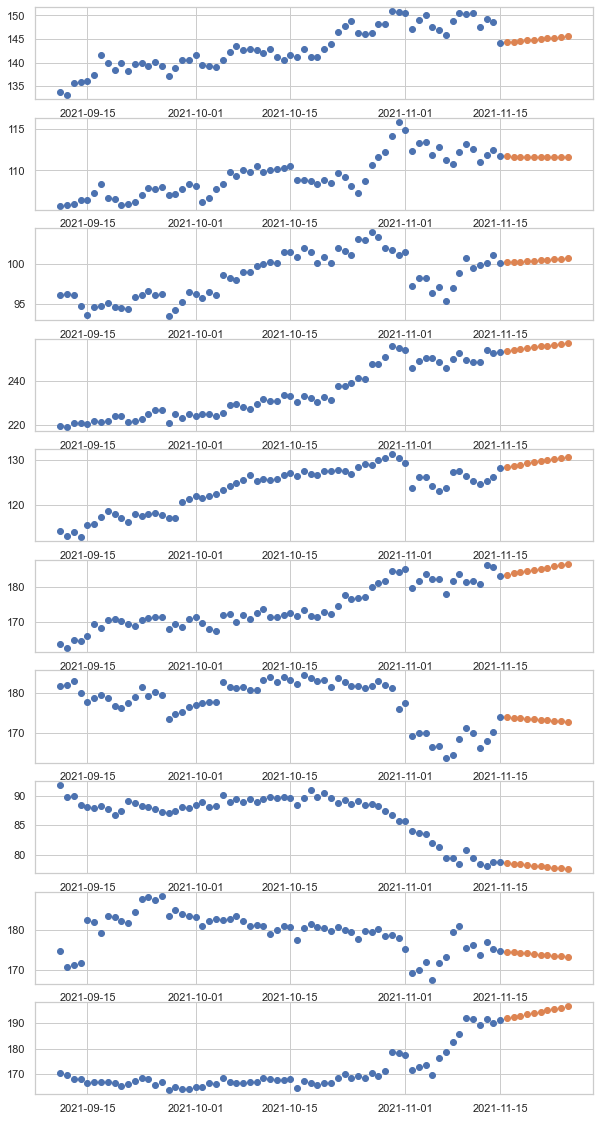

In [361]:
fig, axs = plt.subplots(10, 1, figsize=(10,20))
axs = axs.flatten()

for i, symbol in enumerate(symbols):
    axs[i].scatter(all_stocks_pred.index[:-pred_days], all_stocks_pred[symbol + "_open"][:-pred_days])
    axs[i].scatter(all_stocks_pred.index[-pred_days:], all_stocks_pred[symbol + "_open"][-pred_days:])

In [362]:
# save out these preds
# make CSV

f = open('all_preds_together_daily_pct_chg.csv', 'w')
writer = csv.writer(f)
writer.writerow(["id" , "open"])

stocks_pred_out = {symbol : all_stocks_pred[symbol + "_open"].iloc[-pred_days:] for symbol in symbols}
# print(stocks_pred_out)

for symbol in symbols:
    # day is int 0-8
    # time is HH:MM:SS
    for i, index in enumerate(stocks_pred_out[symbol].index[:-1]):
        date_range = pd.date_range(start=stocks_pred_out[symbol].index[i] +
                                         pd.DateOffset(hours=6, minutes=0, seconds=0), 
                                   end=stocks_pred_out[symbol].index[i] + 
                                         pd.DateOffset(hours=12, minutes=59, seconds=55),
                                   freq='5S')
        p0 = stocks_pred_out[symbol].iloc[i]
        pf = stocks_pred_out[symbol].iloc[i+1]
        n = len(date_range)
        df = pd.DataFrame(data=[p0 + i/(n+1) * (pf - p0) for i in range(n)],
                         index=date_range)
        for index, row in df.iterrows():
            writer.writerow([symbol + "-" + 
                             str(i) + "-" + 
                             ("%02d" % index.hour) + ":" + ("%02d" % index.minute) + ":" + ("%02d" % index.second), 
                             "%.3f" % row])
f.close()

# do again but with more data (hourly)

In [374]:
stocks = {symbol : raw[raw.symbol == symbol].drop(["symbol", "high", "low", "close", "average"], axis=1).astype('float') for symbol in symbols}

for symbol in symbols:
    stocks[symbol] = stocks[symbol].resample('1H').bfill()
    stocks[symbol] = stocks[symbol].drop(stocks[symbol][(stocks[symbol].index.hour < 6) | \
                                                        (stocks[symbol].index.hour >= 13)].index)
        
    stocks[symbol][symbol + "_sma5"]  = stocks[symbol].open.rolling(5*7).mean().shift(1)
    stocks[symbol][symbol + "_sma10"] = stocks[symbol].open.rolling(10*7).mean().shift(1)
    stocks[symbol][symbol + "_sma20"] = stocks[symbol].open.rolling(20*7).mean().shift(1)
    stocks[symbol][symbol + "_ema8"]  = stocks[symbol].open.ewm(8*7).mean().shift(1)
    stocks[symbol][symbol + "_ema20"] = stocks[symbol].open.ewm(20*7).mean().shift(1)
    
    stocks[symbol] = stocks[symbol][20*7:]
    
    stocks[symbol][symbol + "_pct_chg"] = stocks[symbol].open.diff().shift(-1).astype('float') / \
                                       stocks[symbol].open.astype('float') + np.ones(len(stocks[symbol].open))
    
    stocks[symbol] = stocks[symbol].rename(columns={"open": symbol + "_open"})
    
    stocks[symbol] = stocks[symbol][:-1]
    
# concatenate all stocks into one df
all_stocks = pd.concat([stocks[symbol] for symbol in symbols], axis=1)
all_stocks

,A_open,A_sma5,A_sma10,A_sma20,A_ema8,A_ema20,A_pct_chg,B_open,B_sma5,B_sma10,...,I_ema8,I_ema20,I_pct_chg,J_open,J_sma5,J_sma10,J_sma20,J_ema8,J_ema20,J_pct_chg
time,,,,,,,,,,,,,,,,,,,,,
2021-09-11 06:00:00,133.67,134.191143,134.016429,134.221786,134.030308,134.124284,1.001795,105.73,104.986286,104.956143,...,163.212361,163.024087,0.983113,170.69,170.408857,168.844857,169.414571,169.205740,169.171238,0.991915
2021-09-11 07:00:00,133.91,134.107143,134.029286,134.208429,134.023419,134.119197,0.999627,105.67,104.994000,104.984000,...,163.431816,163.154705,0.995575,169.31,170.526000,168.914143,169.370643,169.234120,169.188243,1.002303
2021-09-11 08:00:00,133.86,134.030571,134.063857,134.196786,134.021254,134.116865,1.001793,105.68,104.984857,105.017571,...,163.590420,163.250437,1.001638,169.70,170.593429,168.950000,169.306571,169.235568,169.189601,0.999705
2021-09-11 09:00:00,134.10,133.937429,134.099000,134.184429,134.018180,134.114012,0.999031,105.65,104.971143,105.050143,...,163.731270,163.336279,0.994278,169.65,170.644000,168.973857,169.242714,169.244421,169.195269,1.002122
2021-09-11 10:00:00,133.97,133.844000,134.132143,134.175714,134.019738,134.113857,1.000075,105.56,104.968571,105.080286,...,163.874555,163.423926,0.998062,170.01,170.698286,168.993714,169.183500,169.252140,169.200299,1.001529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-16 07:00:00,145.44,147.394571,147.925571,148.415000,147.626453,145.976235,1.006119,111.57,111.820286,111.807571,...,175.337890,176.540114,0.999083,188.37,190.184857,187.942429,180.532714,183.963361,177.190208,0.998301
2021-11-16 08:00:00,146.33,147.261714,147.907286,148.398214,147.588094,145.972379,0.997130,111.97,111.813714,111.799143,...,175.322137,176.525014,0.997418,188.05,190.122857,188.111286,180.663000,184.040672,177.270589,0.996597
2021-11-16 09:00:00,145.91,147.160286,147.922714,148.384357,147.566021,145.974950,0.998698,111.89,111.816000,111.820286,...,175.303853,176.508875,0.996318,187.41,190.059714,188.275000,180.786571,184.111013,177.348084,0.995198


In [375]:
from tqdm import tqdm

cross_validate = False

train_df, test_df = train_test_split(all_stocks, train_size=0.80)

X_train = train_df.drop([symbol + "_pct_chg" for symbol in symbols], axis=1)
X_test  = test_df.drop( [symbol + "_pct_chg" for symbol in symbols], axis=1)

models = {}

for symbol in tqdm(symbols):
    
    ## set training and testing labels
    y_train = train_df[symbol + "_pct_chg"]   
    y_test  = test_df[ symbol + "_pct_chg"]

    ## model cross-validation
    baseline_params_ = {
        "n_estimators": 200,
        "learning_rate": 0.05,
        "max_depth": 4,
        "gamma": 0.01,
        "random_state": 0
    }
    
    parameters = {
        "n_estimators": [20, 50, 100, 200],
        "learning_rate": [0.05, 0.1, 0.2, 0.5],
        "max_depth": [4, 6, 8, 10],
        "gamma": [0.01, 0.02, 0.05, 0.1],
        "random_state": [0]
    }

    if cross_validate:
        model_obj = xgb.XGBRegressor(objective="reg:squarederror")
        
        search = GridSearchCV(model_obj, parameters)
        search.fit(all_stocks.drop([symbol + "_pct_chg" for symbol in symbols], axis=1), 
                   all_stocks[symbol + "_pct_chg"])

        print(search.best_params_)
    
        ## select optimal model
        models[symbol] = xgb.XGBRegressor(**clf.best_params_, objective="reg:squarederror")
        
    else:
        models[symbol] = xgb.XGBRegressor(**baseline_params_, objective="reg:squarederror")
        
    models[symbol].fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)



  0%|                                                    | 0/10 [00:00<?, ?it/s]

 10%|████▍                                       | 1/10 [00:02<00:20,  2.32s/it]

 20%|████████▊                                   | 2/10 [00:03<00:15,  1.96s/it]

 30%|█████████████▏                              | 3/10 [00:06<00:15,  2.18s/it]

 40%|█████████████████▌                          | 4/10 [00:07<00:12,  2.04s/it]

 50%|██████████████████████                      | 5/10 [00:10<00:11,  2.24s/it]

 60%|██████████████████████████▍                 | 6/10 [00:11<00:07,  1.90s/it]

 70%|██████████████████████████████▊             | 7/10 [00:12<00:05,  1.70s/it]

 80%|███████████████████████████████████▏        | 8/10 [00:15<00:04,  2.01s/it]

 90%|███████████████████████████████████████▌    | 9/10 [00:16<00:01,  1.65s/it]

100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


In [376]:
import copy

all_stocks_pred = copy.deepcopy(all_stocks)
pred_days = 10
pred_hours = 7

time = all_stocks_pred.index[-1:]

for day in range(pred_days):
    
    time += pd.DateOffset(days=1, hours=-7)
    
    for hour in range(pred_hours):
    
        time += pd.DateOffset(hours=1)
    
        new_df = pd.DataFrame(data   =np.repeat(np.NaN, 10*7).reshape(1, -1),
                              columns=all_stocks_pred.columns,
                              index  =time)
    
        all_stocks_pred = all_stocks_pred.append(new_df)

        for symbol in symbols:

            pred_pct = models[symbol].predict(all_stocks_pred.drop([symbol + "_pct_chg" for symbol in symbols], axis=1))[-1]

            all_stocks_pred[symbol + "_open"][-1] = pred_pct * all_stocks_pred[symbol + "_open"][-2]

            all_stocks_pred[symbol + "_sma5"][-1]  = all_stocks_pred[symbol + "_open"].rolling(7*5).mean()[-1]
            all_stocks_pred[symbol + "_sma10"][-1] = all_stocks_pred[symbol + "_open"].rolling(7*10).mean()[-1]
            all_stocks_pred[symbol + "_sma20"][-1] = all_stocks_pred[symbol + "_open"].rolling(7*20).mean()[-1]
            all_stocks_pred[symbol + "_ema8"][-1]  = all_stocks_pred[symbol + "_open"].ewm(7*8).mean()[-1]
            all_stocks_pred[symbol + "_ema20"][-1] = all_stocks_pred[symbol + "_open"].ewm(7*20).mean()[-1]

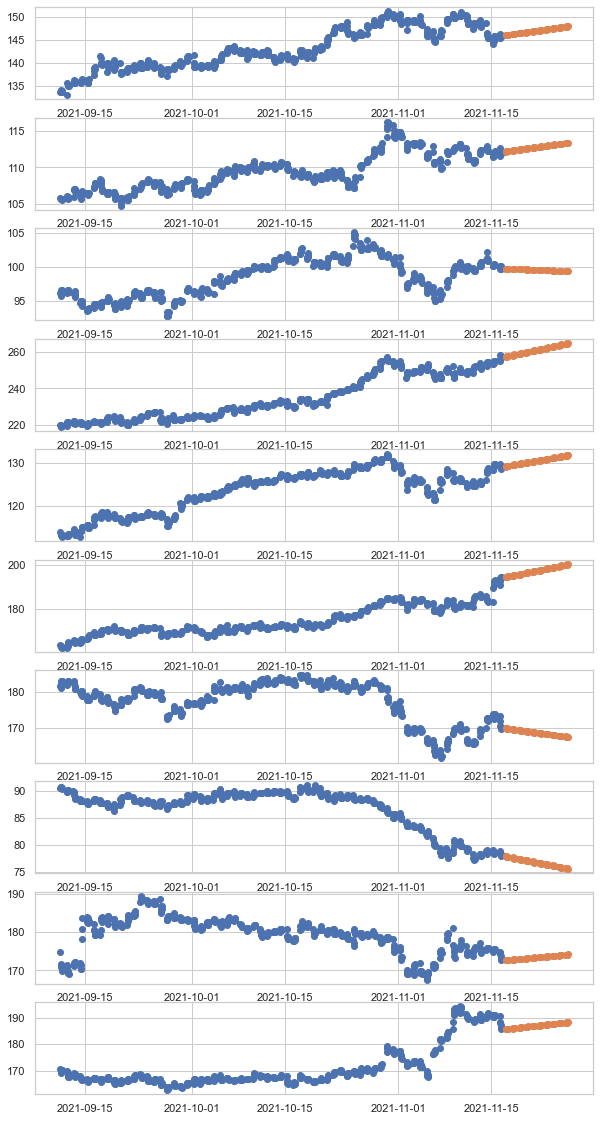

In [377]:
fig, axs = plt.subplots(10, 1, figsize=(10,20))
axs = axs.flatten()

for i, symbol in enumerate(symbols):
    axs[i].scatter(all_stocks_pred.index[:-pred_days*pred_hours], 
                   all_stocks_pred[symbol + "_open"][:-pred_days*pred_hours])
    axs[i].scatter(all_stocks_pred.index[-pred_days*pred_hours:], 
                   all_stocks_pred[symbol + "_open"][-pred_days*pred_hours:])

In [378]:
# save out these preds
# make CSV

f = open('all_preds_together_hourly_pct_chg.csv', 'w')
writer = csv.writer(f)
writer.writerow(["id" , "open"])

stocks_pred_out = {symbol : all_stocks_pred[symbol + "_open"].iloc[-pred_days*pred_hours:] for symbol in symbols}
# print(stocks_pred_out)

for symbol in symbols:
    # day is int 0-8
    # time is HH:MM:SS
    for i, index in enumerate(stocks_pred_out[symbol].index[:-1]):
        date_range = pd.date_range(start=stocks_pred_out[symbol].index[i], 
                                   end  =stocks_pred_out[symbol].index[i] + 
                                         pd.DateOffset(hours=0, minutes=59, seconds=55),
                                   freq='5S')
        p0 = stocks_pred_out[symbol].iloc[i]
        pf = stocks_pred_out[symbol].iloc[i+1]
        n = len(date_range)
        df = pd.DataFrame(data=[p0 + i/(n+1) * (pf - p0) for i in range(n)],
                         index=date_range)
        for index, row in df.iterrows():
            writer.writerow([symbol + "-" + 
                             str(i) + "-" + 
                             ("%02d" % index.hour) + ":" + ("%02d" % index.minute) + ":" + ("%02d" % index.second), 
                             "%.3f" % row])
f.close()

# pt change hourly

In [392]:
stocks = {symbol : raw[raw.symbol == symbol].drop(["symbol", "high", "low", "close", "average"], axis=1).astype('float') for symbol in symbols}

for symbol in symbols:
    stocks[symbol] = stocks[symbol].resample('1H').bfill()
    stocks[symbol] = stocks[symbol].drop(stocks[symbol][(stocks[symbol].index.hour < 6) | \
                                                        (stocks[symbol].index.hour >= 13)].index)
        
    stocks[symbol][symbol + "_sma5"]  = stocks[symbol].open.rolling(5*7).mean().shift(1)
    stocks[symbol][symbol + "_sma10"] = stocks[symbol].open.rolling(10*7).mean().shift(1)
    stocks[symbol][symbol + "_sma20"] = stocks[symbol].open.rolling(20*7).mean().shift(1)
    stocks[symbol][symbol + "_ema8"]  = stocks[symbol].open.ewm(8*7).mean().shift(1)
    stocks[symbol][symbol + "_ema20"] = stocks[symbol].open.ewm(20*7).mean().shift(1)
    
    stocks[symbol] = stocks[symbol][20*7:]
    
    stocks[symbol][symbol + "_pt"] = stocks[symbol].open.shift(-1).astype('float')
    
    stocks[symbol] = stocks[symbol].rename(columns={"open": symbol + "_open"})
    
    stocks[symbol] = stocks[symbol][:-1]
    
# concatenate all stocks into one df
all_stocks = pd.concat([stocks[symbol] for symbol in symbols], axis=1)
all_stocks

,A_open,A_sma5,A_sma10,A_sma20,A_ema8,A_ema20,A_pt,B_open,B_sma5,B_sma10,...,I_ema8,I_ema20,I_pt,J_open,J_sma5,J_sma10,J_sma20,J_ema8,J_ema20,J_pt
time,,,,,,,,,,,,,,,,,,,,,
2021-09-11 06:00:00,133.67,134.191143,134.016429,134.221786,134.030308,134.124284,133.91,105.73,104.986286,104.956143,...,163.212361,163.024087,171.74,170.69,170.408857,168.844857,169.414571,169.205740,169.171238,169.31
2021-09-11 07:00:00,133.91,134.107143,134.029286,134.208429,134.023419,134.119197,133.86,105.67,104.994000,104.984000,...,163.431816,163.154705,170.98,169.31,170.526000,168.914143,169.370643,169.234120,169.188243,169.70
2021-09-11 08:00:00,133.86,134.030571,134.063857,134.196786,134.021254,134.116865,134.10,105.68,104.984857,105.017571,...,163.590420,163.250437,171.26,169.70,170.593429,168.950000,169.306571,169.235568,169.189601,169.65
2021-09-11 09:00:00,134.10,133.937429,134.099000,134.184429,134.018180,134.114012,133.97,105.65,104.971143,105.050143,...,163.731270,163.336279,170.28,169.65,170.644000,168.973857,169.242714,169.244421,169.195269,170.01
2021-09-11 10:00:00,133.97,133.844000,134.132143,134.175714,134.019738,134.113857,133.98,105.56,104.968571,105.080286,...,163.874555,163.423926,169.95,170.01,170.698286,168.993714,169.183500,169.252140,169.200299,170.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-16 07:00:00,145.44,147.394571,147.925571,148.415000,147.626453,145.976235,146.33,111.57,111.820286,111.807571,...,175.337890,176.540114,174.28,188.37,190.184857,187.942429,180.532714,183.963361,177.190208,188.05
2021-11-16 08:00:00,146.33,147.261714,147.907286,148.398214,147.588094,145.972379,145.91,111.97,111.813714,111.799143,...,175.322137,176.525014,173.83,188.05,190.122857,188.111286,180.663000,184.040672,177.270589,187.41
2021-11-16 09:00:00,145.91,147.160286,147.922714,148.384357,147.566021,145.974950,145.72,111.89,111.816000,111.820286,...,175.303853,176.508875,173.19,187.41,190.059714,188.275000,180.786571,184.111013,177.348084,186.51


In [394]:
from tqdm import tqdm

cross_validate = True

train_df, test_df = train_test_split(all_stocks, train_size=0.80)

X_train = train_df.drop([symbol + "_pt" for symbol in symbols], axis=1)
X_test  = test_df.drop( [symbol + "_pt" for symbol in symbols], axis=1)

models = {}

for symbol in tqdm(symbols):
    
    ## set training and testing labels
    y_train = train_df[symbol + "_pt"]   
    y_test  = test_df[ symbol + "_pt"]

    ## model cross-validation
    baseline_params_ = {
        "n_estimators": 200,
        "learning_rate": 0.05,
        "max_depth": 4,
        "gamma": 0.01,
        "random_state": 0
    }
    
    parameters = {
        "n_estimators": [100],
        "learning_rate": [0.05, 0.1, 0.2, 0.5],
        "max_depth": [1, 4, 8],
        "gamma": [0.01, 0.02, 0.05, 0.1],
        "random_state": [0]
    }

    if cross_validate:
        model_obj = xgb.XGBRegressor(objective="reg:squarederror")
        
        search = GridSearchCV(model_obj, parameters)
        search.fit(all_stocks.drop([symbol + "_pt" for symbol in symbols], axis=1), 
                   all_stocks[symbol + "_pt"])

        print(search.best_params_)
    
        ## select optimal model
        models[symbol] = xgb.XGBRegressor(**clf.best_params_, objective="reg:squarederror")
        
    else:
        models[symbol] = xgb.XGBRegressor(**baseline_params_, objective="reg:squarederror")
        
    models[symbol].fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)




  0%|                                                    | 0/10 [00:00<?, ?it/s]

{'gamma': 0.01, 'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 100, 'random_state': 0}





 10%|████▍                                       | 1/10 [01:12<10:54, 72.71s/it]

{'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'random_state': 0}





 20%|████████▊                                   | 2/10 [02:53<10:48, 81.01s/it]

{'gamma': 0.01, 'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 100, 'random_state': 0}





 30%|█████████████▏                              | 3/10 [04:46<10:34, 90.67s/it]/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/base.py", line 554, in score
    return r2_score(y, y_pred, sample_weight=sample_weight)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_regress

/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/base.py", line 554, in score
    return r2_score(y, y_pred, sample_weight=sample_weight)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py", line 677, in r2_score
    y_true, y_pred, multioutput)
  File "/opt/minico

/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/base.py", line 554, in score
    return r2_score(y, y_pred, sample_weight=sample_weight)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py", line 677, in r2_score
    y_true, y_pred, multioutput)
  File "/opt/minico

/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/base.py", line 554, in score
    return r2_score(y, y_pred, sample_weight=sample_weight)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py", line 677, in r2_score
    y_true, y_pred, multioutput)
  File "/opt/minico

/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/base.py", line 554, in score
    return r2_score(y, y_pred, sample_weight=sample_weight)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py", line 677, in r2_score
    y_true, y_pred, multioutput)
  File "/opt/minico

/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/base.py", line 554, in score
    return r2_score(y, y_pred, sample_weight=sample_weight)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py", line 677, in r2_score
    y_true, y_pred, multioutput)
  File "/opt/minico

/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/base.py", line 554, in score
    return r2_score(y, y_pred, sample_weight=sample_weight)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py", line 677, in r2_score
    y_true, y_pred, multioutput)
  File "/opt/minico

/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/base.py", line 554, in score
    return r2_score(y, y_pred, sample_weight=sample_weight)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py", line 677, in r2_score
    y_true, y_pred, multioutput)
  File "/opt/minico

/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/base.py", line 554, in score
    return r2_score(y, y_pred, sample_weight=sample_weight)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py", line 677, in r2_score
    y_true, y_pred, multioutput)
  File "/opt/minico

/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/base.py", line 554, in score
    return r2_score(y, y_pred, sample_weight=sample_weight)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py", line 677, in r2_score
    y_true, y_pred, multioutput)
  File "/opt/minico

{'gamma': 0.01, 'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 100, 'random_state': 0}





 40%|█████████████████▏                         | 4/10 [06:56<10:15, 102.51s/it]

{'gamma': 0.01, 'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 100, 'random_state': 0}





 50%|██████████████████████                      | 5/10 [08:23<08:08, 97.78s/it]

{'gamma': 0.02, 'learning_rate': 0.5, 'max_depth': 8, 'n_estimators': 100, 'random_state': 0}





 60%|██████████████████████████▍                 | 6/10 [09:45<06:12, 93.20s/it]

{'gamma': 0.1, 'learning_rate': 0.5, 'max_depth': 4, 'n_estimators': 100, 'random_state': 0}





 70%|██████████████████████████████▊             | 7/10 [11:35<04:54, 98.15s/it]/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/base.py", line 554, in score
    return r2_score(y, y_pred, sample_weight=sample_weight)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_regress

/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/base.py", line 554, in score
    return r2_score(y, y_pred, sample_weight=sample_weight)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py", line 677, in r2_score
    y_true, y_pred, multioutput)
  File "/opt/minico

/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/base.py", line 554, in score
    return r2_score(y, y_pred, sample_weight=sample_weight)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py", line 677, in r2_score
    y_true, y_pred, multioutput)
  File "/opt/minico

/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/base.py", line 554, in score
    return r2_score(y, y_pred, sample_weight=sample_weight)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py", line 677, in r2_score
    y_true, y_pred, multioutput)
  File "/opt/minico

/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/base.py", line 554, in score
    return r2_score(y, y_pred, sample_weight=sample_weight)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py", line 677, in r2_score
    y_true, y_pred, multioutput)
  File "/opt/minico

/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/base.py", line 554, in score
    return r2_score(y, y_pred, sample_weight=sample_weight)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py", line 677, in r2_score
    y_true, y_pred, multioutput)
  File "/opt/minico

/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/base.py", line 554, in score
    return r2_score(y, y_pred, sample_weight=sample_weight)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py", line 677, in r2_score
    y_true, y_pred, multioutput)
  File "/opt/minico

/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/base.py", line 554, in score
    return r2_score(y, y_pred, sample_weight=sample_weight)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py", line 677, in r2_score
    y_true, y_pred, multioutput)
  File "/opt/minico

/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/base.py", line 554, in score
    return r2_score(y, y_pred, sample_weight=sample_weight)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py", line 677, in r2_score
    y_true, y_pred, multioutput)
  File "/opt/minico

/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/base.py", line 554, in score
    return r2_score(y, y_pred, sample_weight=sample_weight)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py", line 677, in r2_score
    y_true, y_pred, multioutput)
  File "/opt/minico

{'gamma': 0.01, 'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 100, 'random_state': 0}





 80%|██████████████████████████████████▍        | 8/10 [13:27<03:24, 102.25s/it]

{'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'random_state': 0}





 90%|██████████████████████████████████████▋    | 9/10 [15:16<01:44, 104.32s/it]

{'gamma': 0.05, 'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100, 'random_state': 0}





100%|██████████████████████████████████████████| 10/10 [16:41<00:00, 100.16s/it]


In [396]:
import copy

all_stocks_pred = copy.deepcopy(all_stocks)
pred_days = 10
pred_hours = 7

time = all_stocks_pred.index[-1:]

for day in range(pred_days):
    
    time += pd.DateOffset(days=1, hours=-7)
    
    for hour in range(pred_hours):
    
        time += pd.DateOffset(hours=1)
    
        new_df = pd.DataFrame(data   =np.repeat(np.NaN, 10*7).reshape(1, -1),
                              columns=all_stocks_pred.columns,
                              index  =time)
    
        all_stocks_pred = all_stocks_pred.append(new_df)

        for symbol in symbols:

            pred_pt = models[symbol].predict(all_stocks_pred.drop([symbol + "_pt" for symbol in symbols], axis=1))[-1]

            all_stocks_pred[symbol + "_open"][-1] = pred_pt

            all_stocks_pred[symbol + "_sma5"][-1]  = all_stocks_pred[symbol + "_open"].rolling(7*5).mean()[-1]
            all_stocks_pred[symbol + "_sma10"][-1] = all_stocks_pred[symbol + "_open"].rolling(7*10).mean()[-1]
            all_stocks_pred[symbol + "_sma20"][-1] = all_stocks_pred[symbol + "_open"].rolling(7*20).mean()[-1]
            all_stocks_pred[symbol + "_ema8"][-1]  = all_stocks_pred[symbol + "_open"].ewm(7*8).mean()[-1]
            all_stocks_pred[symbol + "_ema20"][-1] = all_stocks_pred[symbol + "_open"].ewm(7*20).mean()[-1]

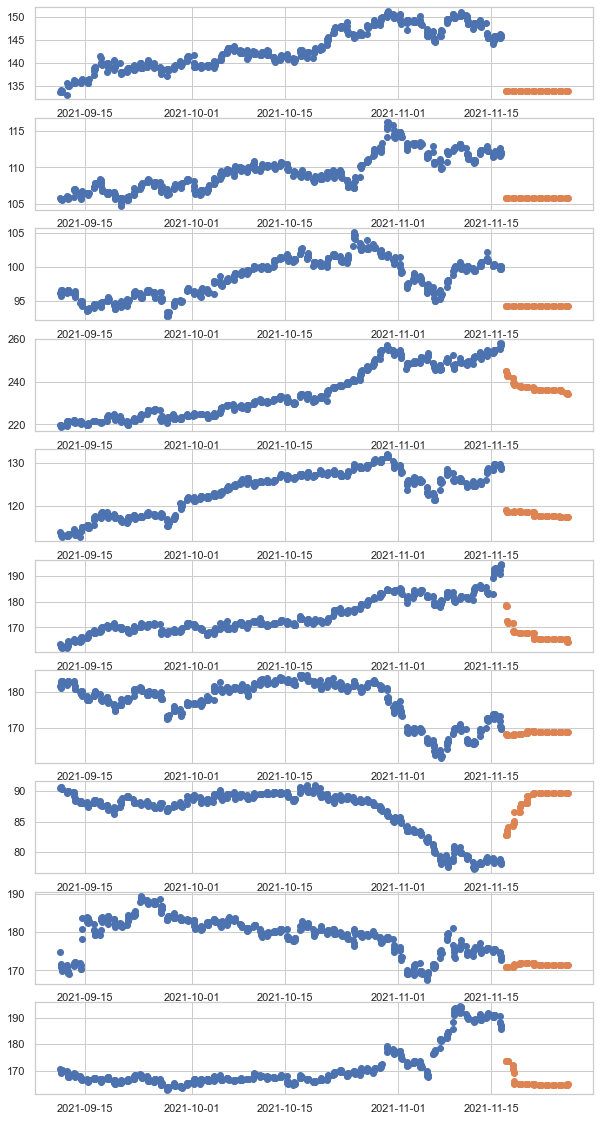

In [397]:
fig, axs = plt.subplots(10, 1, figsize=(10,20))
axs = axs.flatten()

for i, symbol in enumerate(symbols):
    axs[i].scatter(all_stocks_pred.index[:-pred_days*pred_hours], 
                   all_stocks_pred[symbol + "_open"][:-pred_days*pred_hours])
    axs[i].scatter(all_stocks_pred.index[-pred_days*pred_hours:], 
                   all_stocks_pred[symbol + "_open"][-pred_days*pred_hours:])

In [398]:
# save out these preds
# make CSV

f = open('all_preds_together_hourly_pt_chg.csv', 'w')
writer = csv.writer(f)
writer.writerow(["id" , "open"])

stocks_pred_out = {symbol : all_stocks_pred[symbol + "_open"].iloc[-pred_days*pred_hours:] for symbol in symbols}
# print(stocks_pred_out)

for symbol in symbols:
    # day is int 0-8
    # time is HH:MM:SS
    for i, index in enumerate(stocks_pred_out[symbol].index[:-1]):
        date_range = pd.date_range(start=stocks_pred_out[symbol].index[i], 
                                   end  =stocks_pred_out[symbol].index[i] + 
                                         pd.DateOffset(hours=0, minutes=59, seconds=55),
                                   freq='5S')
        p0 = stocks_pred_out[symbol].iloc[i]
        pf = stocks_pred_out[symbol].iloc[i+1]
        n = len(date_range)
        df = pd.DataFrame(data=[p0 + i/(n+1) * (pf - p0) for i in range(n)],
                         index=date_range)
        for index, row in df.iterrows():
            writer.writerow([symbol + "-" + 
                             str(i) + "-" + 
                             ("%02d" % index.hour) + ":" + ("%02d" % index.minute) + ":" + ("%02d" % index.second), 
                             "%.3f" % row])
f.close()

# do with lag vars, independently by stock, or clustered

In [431]:
stocks = {symbol : raw[raw.symbol == symbol].drop(["symbol", "high", "low", "close", "average"], axis=1).astype('float') for symbol in symbols}

for symbol in symbols:
    stocks[symbol] = stocks[symbol].resample('1D').bfill()
        
    for lag in [1, 2, 3, 4, 5]:
        stocks[symbol]["lag" + str(lag)] = (stocks[symbol].open.shift(lag) - stocks[symbol].open) / stocks[symbol].open
        
    stocks[symbol]["lead1"] = (stocks[symbol].open.shift(-1) - stocks[symbol].open) / stocks[symbol].open
    
    stocks[symbol] = stocks[symbol][5:-1]
    
stocks["A"]

,open,lag1,lag2,lag3,lag4,lag5,lead1
time,,,,,,,
2021-08-27,135.69,0.001253,-0.002727,-0.010465,-0.004864,-0.001105,-0.000295
2021-08-28,135.65,0.000295,0.001548,-0.002433,-0.010173,-0.004571,-0.010542
2021-08-29,134.22,0.010654,0.010952,0.012219,0.008195,0.000373,-0.016838
2021-08-30,131.96,0.017126,0.027963,0.028266,0.029554,0.025462,0.003637
2021-08-31,132.44,-0.003624,0.013440,0.024237,0.024539,0.025823,0.002492
...,...,...,...,...,...,...,...
2021-11-11,150.48,-0.000797,0.000332,-0.011563,-0.030369,-0.023658,-0.020069
2021-11-12,147.46,0.020480,0.019666,0.020819,0.008680,-0.010511,0.012275
2021-11-13,149.27,-0.012126,0.008106,0.007302,0.008441,-0.003551,-0.004087


In [432]:
%%time

parameters = {
    'n_estimators': [10, 50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [2, 4, 6, 8],
    'gamma': [0.01, 0.02, 0.05, 0.1],
    'random_state': [0]
}

model = xgb.XGBRegressor(objective="reg:squarederror")
clf   = GridSearchCV(model, parameters)

clf.fit(stocks["A"].drop(["open", "lead1"], axis=1), stocks["A"].lead1)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'gamma': 0.01, 'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 200, 'random_state': 0}
Best validation score = -0.05192324531776711
CPU times: user 3min 49s, sys: 23.1 s, total: 4min 12s
Wall time: 2min 14s


In [433]:
train_df, test_df = train_test_split(stocks["A"], train_size=0.80)

X_train = train_df.drop(["open", "lead1"], axis=1)
X_test  = test_df.drop( ["open", "lead1"], axis=1)
y_train = train_df["lead1"]   
y_test  = test_df["lead1"]

model = xgb.XGBRegressor(**clf.best_params_, objective="reg:squarederror")
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.01, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [434]:
xgb.plot_importance(model);

ValueError: Booster.get_score() results in empty.  This maybe caused by having all trees as decision dumps.

In [449]:
import copy

stocks_pred = copy.deepcopy(stocks)
pred_days = 100
symbol = "A"

for i, day in enumerate(range(pred_days)):
    
    pred_lead_pct = model.predict(stocks_pred[symbol].drop(["open", "lead1"], axis=1))[-1]
    prev_open = stocks_pred[symbol].open.iloc[-1]
    new_open  = prev_open*(1 + pred_lead_pct)
    change = new_open - prev_open
    
    new_df = pd.DataFrame([[new_open, 
                            np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN]], 
                          columns=stocks_pred[symbol].columns,
                          index=stocks_pred[symbol].index[-1:]+pd.DateOffset(days=1))

    stocks_pred[symbol] = stocks_pred[symbol].append(new_df)

    for lag in [1, 2, 3, 4, 5]:
        stocks_pred[symbol].iloc[-1, lag] = (stocks_pred[symbol].open.shift(lag)[-1] - 
                                             stocks_pred[symbol].open[-1]) / stocks_pred[symbol].open[-1]

In [450]:
stocks_pred["A"].tail(12)

,open,lag1,lag2,lag3,lag4,lag5,lead1
time,,,,,,,
2022-02-12,150.561953,-0.000492,-0.000984,-0.001475,-0.001967,-0.002458,NaN
2022-02-13,150.636064,-0.000492,-0.000984,-0.001475,-0.001967,-0.002458,NaN
2022-02-14,150.710212,-0.000492,-0.000984,-0.001475,-0.001967,-0.002458,NaN
2022-02-15,150.784396,-0.000492,-0.000984,-0.001475,-0.001967,-0.002458,NaN
2022-02-16,150.858616,-0.000492,-0.000984,-0.001475,-0.001967,-0.002458,NaN
2022-02-17,150.932874,-0.000492,-0.000984,-0.001475,-0.001967,-0.002458,NaN
2022-02-18,151.007168,-0.000492,-0.000984,-0.001475,-0.001967,-0.002458,NaN
2022-02-19,151.081498,-0.000492,-0.000984,-0.001475,-0.001967,-0.002458,NaN
2022-02-20,151.155865,-0.000492,-0.000984,-0.001475,-0.001967,-0.002458,NaN


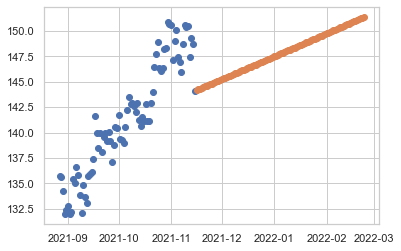

In [451]:
# fig, axs = plt.subplots(5, 2, figsize=(10,10))
# axs = axs.flatten()

# for i, symbol in enumerate(symbols):
#     axs[i].scatter(stocks_pred[symbol].index[:-pred_days], stocks_pred[symbol].open[:-pred_days])
#     axs[i].scatter(stocks_pred[symbol].index[-pred_days:], stocks_pred[symbol].open[-pred_days:])

plt.scatter(stocks_pred[symbol].index[:-pred_days], stocks_pred[symbol].open[:-pred_days])
plt.scatter(stocks_pred[symbol].index[-pred_days:], stocks_pred[symbol].open[-pred_days:])

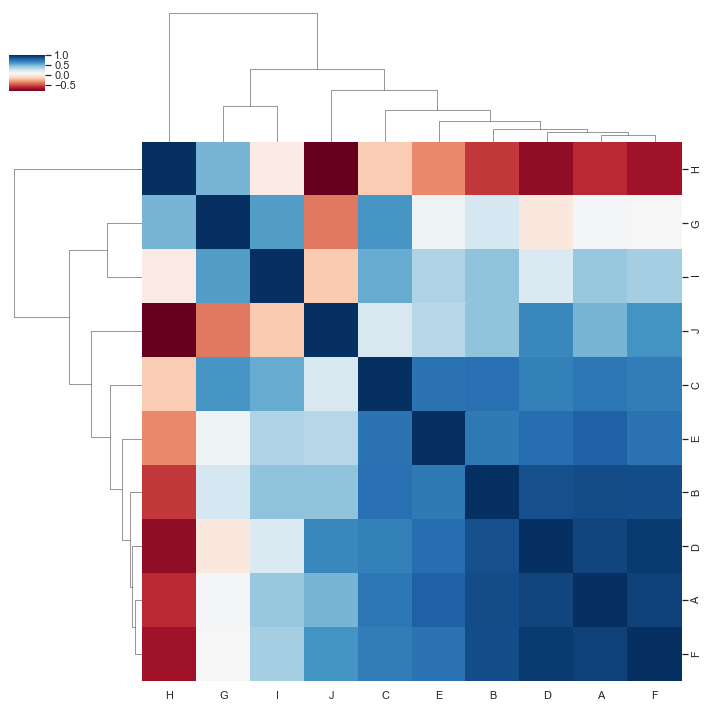

In [639]:
sns.clustermap(stocks_open_normalized.corr(), cmap="RdBu", method="average")
plt.gca().set_aspect('equal')

In [489]:
stocks = {symbol : raw[raw.symbol == symbol].drop(["symbol", "high", "low", "close", "average"], axis=1).astype('float') for symbol in symbols}

for symbol in symbols:
    stocks[symbol] = stocks[symbol].resample('1D').bfill()
        
    for lag in [1, 2, 3, 4, 5, 7, 10]:
        stocks[symbol]["lag" + str(lag)] = (stocks[symbol].open.shift(lag) - stocks[symbol].open) / stocks[symbol].open
        
    stocks[symbol]["lead1"] = (stocks[symbol].open.shift(-1) - stocks[symbol].open) / stocks[symbol].open
    
    stocks[symbol] = stocks[symbol][10:-1]
    
stocks_clust = pd.concat([stocks[symbol] for symbol in ["A", "B", "C", "D", "E", "F", "J"]])
stocks_clust

,open,lag1,lag2,lag3,lag4,lag5,lag7,lag10,lead1
time,,,,,,,,,
2021-09-01,132.77,-0.002486,-0.006101,0.010921,0.021692,0.021993,0.019206,0.020863,-0.005875
2021-09-02,131.99,0.005910,0.003409,-0.000227,0.016895,0.027729,0.029320,0.023032,0.001440
2021-09-03,132.18,-0.001437,0.004464,0.001967,-0.001664,0.015433,0.026555,0.015812,0.024588
2021-09-04,135.43,-0.023998,-0.025401,-0.019641,-0.022078,-0.025622,0.001624,-0.000812,-0.002658
2021-09-05,135.07,0.002665,-0.021396,-0.022803,-0.017028,-0.019471,-0.006293,0.005849,0.011401
...,...,...,...,...,...,...,...,...,...
2021-11-11,191.34,0.002509,-0.029424,-0.045835,-0.067158,-0.079074,-0.092296,-0.072175,-0.011602
2021-11-12,189.12,0.011739,0.014277,-0.018031,-0.034634,-0.056208,-0.102369,-0.091899,0.011844
2021-11-13,191.36,-0.011706,-0.000105,0.002404,-0.029526,-0.045934,-0.079170,-0.096938,-0.006689


In [494]:
%%time

parameters = {
    'n_estimators': [10, 50, 100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [1, 5, 10],
    'gamma': [0.01, 0.02, 0.05],
    'random_state': [0]
}

model = xgb.XGBRegressor(objective="reg:squarederror")
clf   = GridSearchCV(model, parameters)

clf.fit(stocks_clust.drop(["open", "lead1"], axis=1), stocks_clust.lead1)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'gamma': 0.01, 'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 100, 'random_state': 0}
Best validation score = -0.0030381492232084196
CPU times: user 3min 39s, sys: 16.4 s, total: 3min 56s
Wall time: 3min 8s


In [495]:
train_df, test_df = train_test_split(stocks_clust, train_size=0.80)

X_train = train_df.drop(["open", "lead1"], axis=1)
X_test  = test_df.drop( ["open", "lead1"], axis=1)
y_train = train_df["lead1"]   
y_test  = test_df["lead1"]

model = xgb.XGBRegressor(**clf.best_params_, objective="reg:squarederror")
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.01, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=1,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [496]:
xgb.plot_importance(model);

ValueError: Booster.get_score() results in empty.  This maybe caused by having all trees as decision dumps.

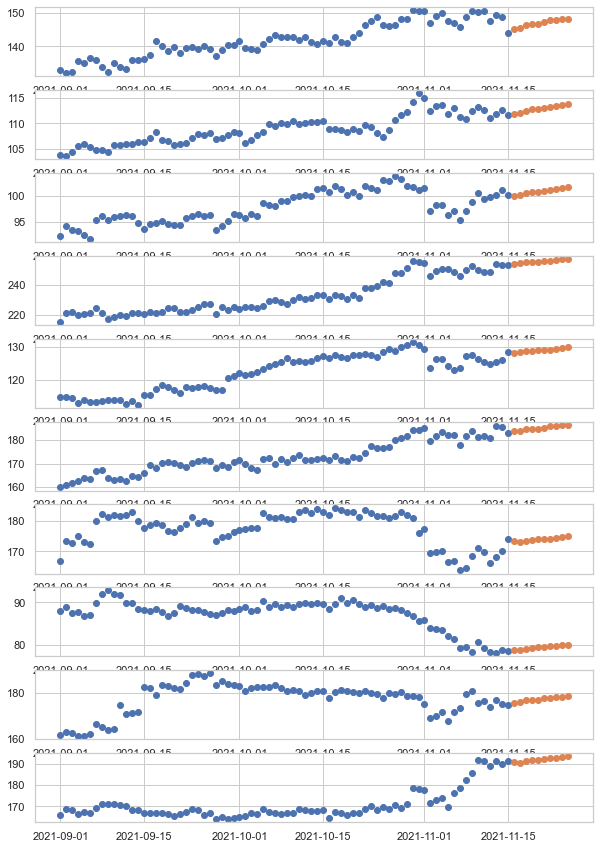

In [502]:
stocks_pred = copy.deepcopy(stocks)
pred_days = 10

for symbol in symbols:

    for i, day in enumerate(range(pred_days)):

        pred_lead_pct = model.predict(stocks_pred[symbol].drop(["open", "lead1"], axis=1))[-1]
        prev_open = stocks_pred[symbol].open.iloc[-1]
        new_open  = prev_open*(1 + pred_lead_pct)
        change = new_open - prev_open

        new_df = pd.DataFrame([[new_open, 
                                np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN]], 
                              columns=stocks_pred[symbol].columns,
                              index=stocks_pred[symbol].index[-1:]+pd.DateOffset(days=1))

        stocks_pred[symbol] = stocks_pred[symbol].append(new_df)

        for j, lag in enumerate([1, 2, 3, 4, 5, 7, 10]):
            stocks_pred[symbol].iloc[-1, j+1] = (stocks_pred[symbol].open.shift(lag)[-1] - 
                                                 stocks_pred[symbol].open[-1]) / stocks_pred[symbol].open[-1]

fig, axs = plt.subplots(10, 1, figsize=(10,15))
axs = axs.flatten()

for i, symbol in enumerate(symbols):
    axs[i].scatter(stocks_pred[symbol].index[:-pred_days], stocks_pred[symbol].open[:-pred_days])
    axs[i].scatter(stocks_pred[symbol].index[-pred_days:], stocks_pred[symbol].open[-pred_days:])

## Ridge model

In [500]:
from sklearn.linear_model import RidgeCV

model = RidgeCV(alphas=[1E-2, 1E-1, 1E0, 1E1, 1E2], cv=10)
model.fit(stocks_clust.drop(["open", "lead1"], axis=1), stocks_clust.lead1)

RidgeCV(alphas=array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]), cv=10)

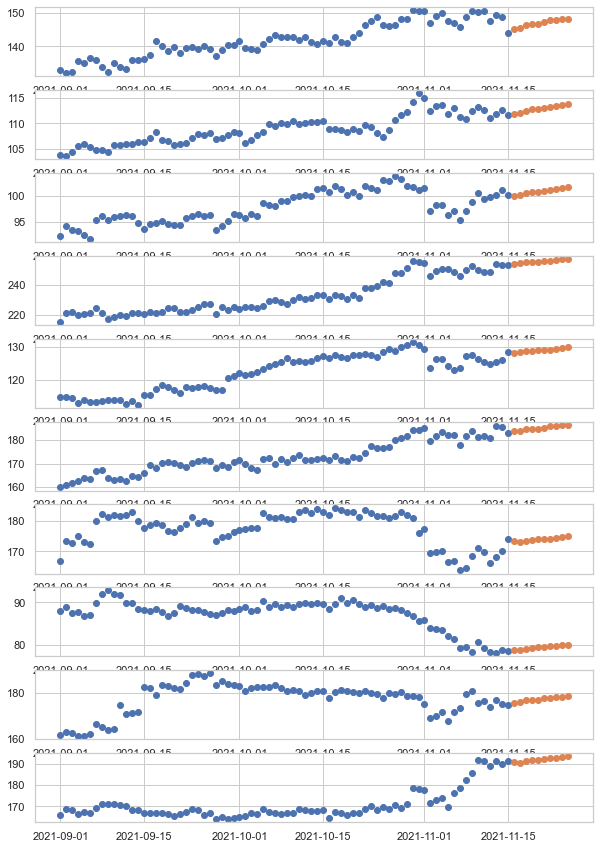

In [503]:
stocks_pred = copy.deepcopy(stocks)
pred_days = 10

for symbol in symbols:

    for i, day in enumerate(range(pred_days)):

        pred_lead_pct = model.predict(stocks_pred[symbol].drop(["open", "lead1"], axis=1))[-1]
        prev_open = stocks_pred[symbol].open.iloc[-1]
        new_open  = prev_open*(1 + pred_lead_pct)
        change    = new_open - prev_open

        new_df = pd.DataFrame([[new_open, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN]], 
                              columns=stocks_pred[symbol].columns,
                              index=stocks_pred[symbol].index[-1:]+pd.DateOffset(days=1))

        stocks_pred[symbol] = stocks_pred[symbol].append(new_df)

        for j, lag in enumerate([1, 2, 3, 4, 5, 7, 10]):
            stocks_pred[symbol].iloc[-1, j+1] = (stocks_pred[symbol].open.shift(lag)[-1] - 
                                                 stocks_pred[symbol].open[-1]) / stocks_pred[symbol].open[-1]

fig, axs = plt.subplots(10, 1, figsize=(10,15))
axs = axs.flatten()
            
for i, symbol in enumerate(symbols):
    axs[i].scatter(stocks_pred[symbol].index[:-pred_days], stocks_pred[symbol].open[:-pred_days])
    axs[i].scatter(stocks_pred[symbol].index[-pred_days:], stocks_pred[symbol].open[-pred_days:])

In [504]:
model.coef_

array([ 0.03972082,  0.02423101, -0.00897535,  0.11997412, -0.12708247,
        0.079427  ,  0.00076294])

## XGBoost with one-hot cluster ids

In [506]:
stocks = {symbol : raw[raw.symbol == symbol].drop(["symbol", "high", "low", "close", "average"], axis=1).astype('float') for symbol in symbols}

for symbol in symbols:
    stocks[symbol] = stocks[symbol].resample('1D').bfill()
        
    for lag in [1, 2, 3, 4, 5, 7, 10]:
        stocks[symbol]["lag" + str(lag)] = (stocks[symbol].open.shift(lag) - stocks[symbol].open) / stocks[symbol].open
        
    stocks[symbol]["lead1"] = (stocks[symbol].open.shift(-1) - stocks[symbol].open) / stocks[symbol].open
    stocks[symbol]["clust0"] = int(symbol in ["A", "B", "C", "D", "E", "F", "J"])
    stocks[symbol]["clust1"] = int(symbol in ["G", "I"])
    stocks[symbol]["clust2"] = int(symbol in ["H"])
    
    stocks[symbol] = stocks[symbol][10:-1]
    
stocks_clust = pd.concat([stocks[symbol] for symbol in symbols])
stocks_clust

,open,lag1,lag2,lag3,lag4,lag5,lag7,lag10,lead1,clust0,clust1,clust2
time,,,,,,,,,,,,
2021-09-01,132.77,-0.002486,-0.006101,0.010921,0.021692,0.021993,0.019206,0.020863,-0.005875,1,0,0
2021-09-02,131.99,0.005910,0.003409,-0.000227,0.016895,0.027729,0.029320,0.023032,0.001440,1,0,0
2021-09-03,132.18,-0.001437,0.004464,0.001967,-0.001664,0.015433,0.026555,0.015812,0.024588,1,0,0
2021-09-04,135.43,-0.023998,-0.025401,-0.019641,-0.022078,-0.025622,0.001624,-0.000812,-0.002658,1,0,0
2021-09-05,135.07,0.002665,-0.021396,-0.022803,-0.017028,-0.019471,-0.006293,0.005849,0.011401,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-11,191.34,0.002509,-0.029424,-0.045835,-0.067158,-0.079074,-0.092296,-0.072175,-0.011602,1,0,0
2021-11-12,189.12,0.011739,0.014277,-0.018031,-0.034634,-0.056208,-0.102369,-0.091899,0.011844,1,0,0
2021-11-13,191.36,-0.011706,-0.000105,0.002404,-0.029526,-0.045934,-0.079170,-0.096938,-0.006689,1,0,0


In [515]:
%%time

parameters = {
    'n_estimators': [10, 50, 100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [5, 10],
    'gamma': [0.01, 0.02, 0.05],
    'random_state': [0]
}

model = xgb.XGBRegressor(objective="reg:squarederror")
clf   = GridSearchCV(model, parameters)

clf.fit(stocks_clust.drop(["open", "lead1"], axis=1), stocks_clust.lead1)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'gamma': 0.01, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'random_state': 0}
Best validation score = -0.007600251024656135
CPU times: user 3min 41s, sys: 11.4 s, total: 3min 52s
Wall time: 1min 55s


In [517]:
train_df, test_df = train_test_split(stocks_clust, train_size=0.80)

X_train = train_df.drop(["open", "lead1"], axis=1)
X_test  = test_df.drop( ["open", "lead1"], axis=1)
y_train = train_df["lead1"]   
y_test  = test_df["lead1"]

model = xgb.XGBRegressor(**clf.best_params_, objective="reg:squarederror")
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

# xgb.plot_importance(model);

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.01, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

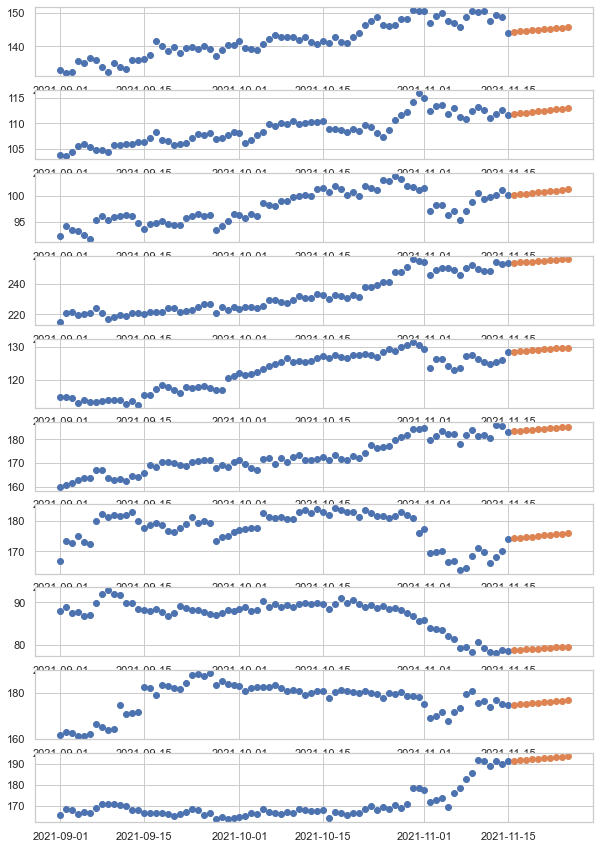

In [518]:
stocks_pred = copy.deepcopy(stocks)
pred_days = 10

for symbol in symbols:

    for i, day in enumerate(range(pred_days)):

        pred_lead_pct = model.predict(stocks_pred[symbol].drop(["open", "lead1"], axis=1))[-1]
        prev_open = stocks_pred[symbol].open.iloc[-1]
        new_open  = prev_open*(1 + pred_lead_pct)
        change    = new_open - prev_open

        new_df = pd.DataFrame([[new_open, *np.repeat(np.NaN, 8), *stocks_pred[symbol].iloc[-1, -3:]]], 
                              columns=stocks_pred[symbol].columns,
                              index=stocks_pred[symbol].index[-1:]+pd.DateOffset(days=1))

        stocks_pred[symbol] = stocks_pred[symbol].append(new_df)

        for j, lag in enumerate([1, 2, 3, 4, 5, 7, 10]):
            stocks_pred[symbol].iloc[-1, j+1] = (stocks_pred[symbol].open.shift(lag)[-1] - 
                                                 stocks_pred[symbol].open[-1]) / stocks_pred[symbol].open[-1]

fig, axs = plt.subplots(10, 1, figsize=(10,15))
axs = axs.flatten()
            
for i, symbol in enumerate(symbols):
    axs[i].scatter(stocks_pred[symbol].index[:-pred_days], stocks_pred[symbol].open[:-pred_days])
    axs[i].scatter(stocks_pred[symbol].index[-pred_days:], stocks_pred[symbol].open[-pred_days:])

## Ridge model with one-hot encoding of cluster ids

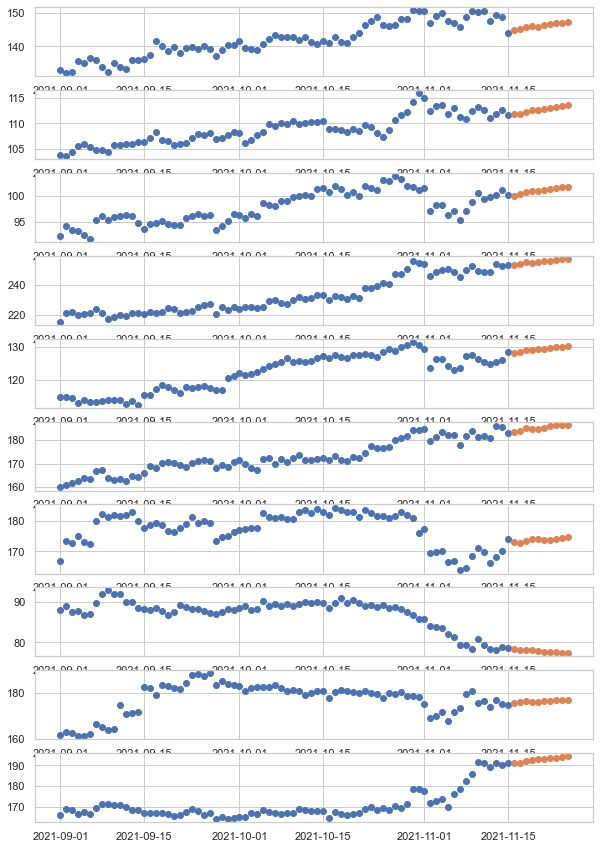

In [519]:
model = RidgeCV(alphas=[1E-2, 1E-1, 1E0, 1E1, 1E2], cv=10)
model.fit(stocks_clust.drop(["open", "lead1"], axis=1), stocks_clust.lead1)

stocks_pred = copy.deepcopy(stocks)
pred_days = 10

for symbol in symbols:

    for i, day in enumerate(range(pred_days)):

        pred_lead_pct = model.predict(stocks_pred[symbol].drop(["open", "lead1"], axis=1))[-1]
        prev_open = stocks_pred[symbol].open.iloc[-1]
        new_open  = prev_open*(1 + pred_lead_pct)
        change    = new_open - prev_open

        new_df = pd.DataFrame([[new_open, *np.repeat(np.NaN, 8), *stocks_pred[symbol].iloc[-1, -3:]]], 
                              columns=stocks_pred[symbol].columns,
                              index=stocks_pred[symbol].index[-1:]+pd.DateOffset(days=1))

        stocks_pred[symbol] = stocks_pred[symbol].append(new_df)

        for j, lag in enumerate([1, 2, 3, 4, 5, 7, 10]):
            stocks_pred[symbol].iloc[-1, j+1] = (stocks_pred[symbol].open.shift(lag)[-1] - 
                                                 stocks_pred[symbol].open[-1]) / stocks_pred[symbol].open[-1]

fig, axs = plt.subplots(10, 1, figsize=(10,15))
axs = axs.flatten()
            
for i, symbol in enumerate(symbols):
    axs[i].scatter(stocks_pred[symbol].index[:-pred_days], stocks_pred[symbol].open[:-pred_days])
    axs[i].scatter(stocks_pred[symbol].index[-pred_days:], stocks_pred[symbol].open[-pred_days:])

<BarContainer object of 11 artists>

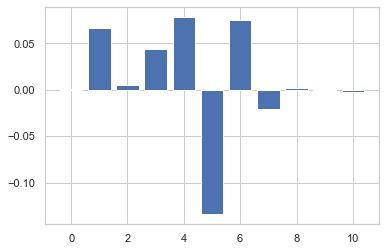

In [524]:
plt.bar(range(11), [model.intercept_, *model.coef_])

## Ridge submodels per clusters

train loss: 1.172e-04
test loss:  1.022e-04
train loss: 2.300e-04
test loss:  1.420e-04
train loss: 1.154e-04
test loss:  1.679e-04


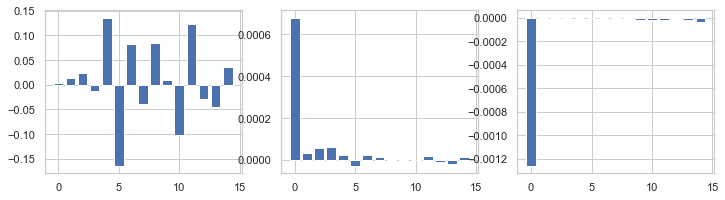

In [688]:
from sklearn.linear_model import RidgeCV, Ridge

stocks = {symbol : raw[raw.symbol == symbol].drop(["symbol", "high", "low", "close", "average"], axis=1).astype('float') for symbol in symbols}
lags   = np.arange(1, 15)

for symbol in symbols:
    
    stocks[symbol] = stocks[symbol].resample('1D').bfill()
                  
    for lag in lags:
        stocks[symbol]["lag" + str(lag)] = (stocks[symbol].open.shift(lag) - stocks[symbol].open) / stocks[symbol].open
        
    stocks[symbol]["lead1"] = (stocks[symbol].open.shift(-1) - stocks[symbol].open) / stocks[symbol].open
    
    stocks[symbol] = stocks[symbol][max(lags):-1]

    
clusters = {0 : ["A", "B", "C", "D", "E", "F", "J"], 1 : ["G", "I"], 2 : "H"}
alphas   = [1E-3, 1E-2, 1E-1, 1E0, 1E1, 1E2]
models   = {
    "clust" + str(i) : RidgeCV(alphas=alphas) 
    for i in range(3)
}

for i, cluster in clusters.items():
        
    stocks_clust = pd.concat([stocks[symbol] for symbol in cluster])
    
    X = stocks_clust.drop(["open", "lead1"], axis=1)
    y = stocks_clust.lead1
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
    
    model = models["clust" + str(i)]
    model.fit(X, y)
    
    # optimal cross-validated model
    model = Ridge(alpha=model.alpha_, random_state=0)
    model.fit(X_train, y_train)
    print("train loss: %4.3e" %MSE(y_train, model.predict(X_train)))
    print("test loss:  %4.3e" %MSE(y_test,  model.predict(X_test)))
    
fig, axs = plt.subplots(1, 3, figsize=(12,3))
axs = axs.flatten()

for i, cluster in clusters.items():
    axs[i].bar(range(len(lags)+1), [models["clust" + str(i)].intercept_, *models["clust" + str(i)].coef_])  
    
plt.savefig("ridge_coeffs.png")

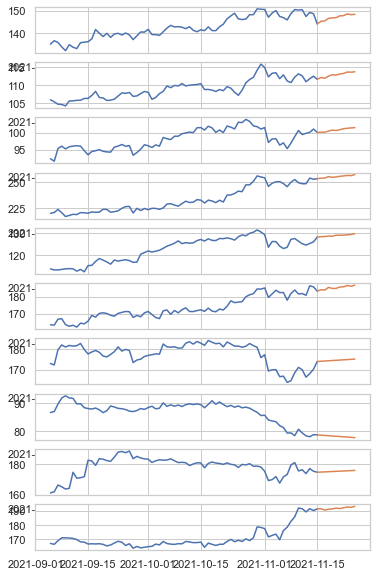

In [689]:
stocks_pred = copy.deepcopy(stocks)
pred_days = 10

for i, cluster in clusters.items():
    
    for symbol in cluster:

        for j, day in enumerate(range(pred_days)):

            pred_lead_pct = models["clust" + str(i)].predict(stocks_pred[symbol].drop(["open", "lead1"], axis=1))[-1]
            prev_open = stocks_pred[symbol].open.iloc[-1]
            new_open  = prev_open*(1 + pred_lead_pct)
            change    = new_open - prev_open

            new_df = pd.DataFrame([[new_open, *np.repeat(np.NaN, len(lags) + 1)]], 
                                  columns=stocks_pred[symbol].columns,
                                  index=stocks_pred[symbol].index[-1:]+pd.DateOffset(days=1))

            stocks_pred[symbol] = stocks_pred[symbol].append(new_df)

            for k, lag in enumerate(lags):
                stocks_pred[symbol].iloc[-1, k+1] = (stocks_pred[symbol].open.shift(lag)[-1] - 
                                                     stocks_pred[symbol].open[-1]) / stocks_pred[symbol].open[-1]

fig, axs = plt.subplots(10, 1, figsize=(6,10))
axs = axs.flatten()

for i, symbol in enumerate(symbols):
    axs[i].plot(stocks[symbol].index, stocks[symbol].open)
    axs[i].plot(stocks_pred[symbol].index[-pred_days-1:], stocks_pred[symbol].open[-pred_days-1:])
    
plt.savefig("ridge_stock_preds.png")

In [690]:
# make CSV

f = open('all_preds_clustered_daily_lags_ridge.csv', 'w')
writer = csv.writer(f)
writer.writerow(["id" , "open"])

stocks_pred_out = {symbol : stocks_pred[symbol].open.iloc[-pred_days:] for symbol in symbols}
# print(stocks_pred_out)

for symbol in symbols:
    # day is int 0-8
    # time is HH:MM:SS
    for i, index in enumerate(stocks_pred_out[symbol].index[:-1]):
        date_range = pd.date_range(start=stocks_pred_out[symbol].index[i] +
                                         pd.DateOffset(hours=6, minutes=0, seconds=0), 
                                   end=stocks_pred_out[symbol].index[i] + 
                                         pd.DateOffset(hours=12, minutes=59, seconds=55),
                                   freq='5S')
        p0 = stocks_pred_out[symbol].iloc[i]
        pf = stocks_pred_out[symbol].iloc[i+1]
        n = len(date_range)
        df = pd.DataFrame(data=[p0 + i/(n+1) * (pf - p0) for i in range(n)],
                         index=date_range)
        for index, row in df.iterrows():
            writer.writerow([symbol + "-" + 
                             str(i) + "-" + 
                             ("%02d" % index.hour) + ":" + ("%02d" % index.minute) + ":" + ("%02d" % index.second), 
                             "%.3f" % row])
f.close()

## ElasticNet CV by cluster

train loss: 1.086e-04
test loss:  1.545e-04
train loss: 1.932e-04
test loss:  3.408e-04
train loss: 1.132e-04
test loss:  1.742e-04


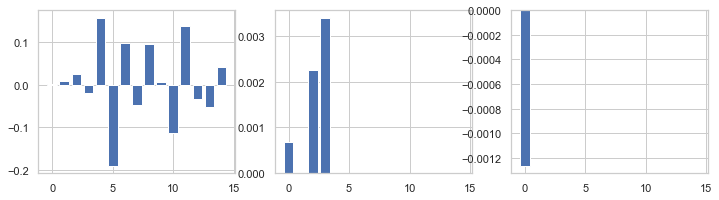

In [691]:
from sklearn.linear_model import ElasticNetCV, ElasticNet

stocks = {symbol : raw[raw.symbol == symbol].drop(["symbol", "high", "low", "close", "average"], axis=1).astype('float') for symbol in symbols}
lags   = np.arange(1, 15)

for symbol in symbols:
    
    stocks[symbol] = stocks[symbol].resample('1D').bfill()
                  
    for lag in lags:
        stocks[symbol]["lag" + str(lag)] = (stocks[symbol].open.shift(lag) - stocks[symbol].open) / stocks[symbol].open
        
    stocks[symbol]["lead1"] = (stocks[symbol].open.shift(-1) - stocks[symbol].open) / stocks[symbol].open
    
    stocks[symbol] = stocks[symbol][max(lags):-1]

clusters  = {0 : ["A", "B", "C", "D", "E", "F", "J"], 1 : ["G", "I"], 2 : "H"}
l1_ratios = [.01, .05, .1, .3, .5, .7, .9, .95, .99, 1]
models    = {
    "clust" + str(i) : ElasticNetCV(l1_ratio=l1_ratios) 
    for i in range(3)
}

for i, cluster in clusters.items():
        
    stocks_clust = pd.concat([stocks[symbol] for symbol in cluster])
    
    X = stocks_clust.drop(["open", "lead1"], axis=1)
    y = stocks_clust.lead1
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
    
    model = models["clust" + str(i)]
    model.fit(X, y)
    
    # optimal cross-validated model
    model = ElasticNet(alpha=model.alpha_, l1_ratio=model.l1_ratio_, random_state=0)
    model.fit(X_train, y_train)
    print("train loss: %4.3e" %MSE(y_train, model.predict(X_train)))
    print("test loss:  %4.3e" %MSE(y_test,  model.predict(X_test)))
    
fig, axs = plt.subplots(1, 3, figsize=(12,3))
axs = axs.flatten()

for i, cluster in clusters.items():
    axs[i].bar(range(len(lags)+1), [models["clust" + str(i)].intercept_, *models["clust" + str(i)].coef_])
    
plt.savefig("elastic_coeffs.png")

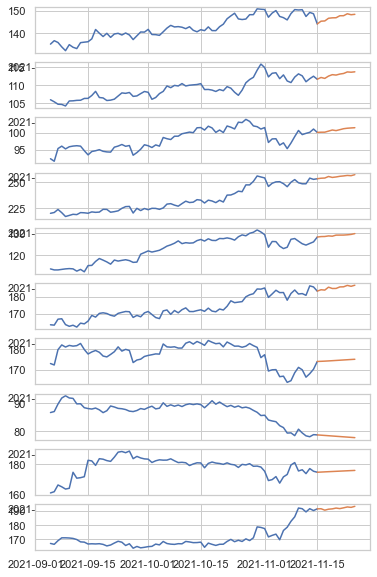

In [692]:
stocks_pred = copy.deepcopy(stocks)
pred_days = 10

for i, cluster in clusters.items():
    
    for symbol in cluster:

        for j, day in enumerate(range(pred_days)):

            pred_lead_pct = models["clust" + str(i)].predict(stocks_pred[symbol].drop(["open", "lead1"], axis=1))[-1]
            prev_open = stocks_pred[symbol].open.iloc[-1]
            new_open  = prev_open*(1 + pred_lead_pct)
            change    = new_open - prev_open

            new_df = pd.DataFrame([[new_open, *np.repeat(np.NaN, len(lags) + 1)]], 
                                  columns=stocks_pred[symbol].columns,
                                  index=stocks_pred[symbol].index[-1:]+pd.DateOffset(days=1))

            stocks_pred[symbol] = stocks_pred[symbol].append(new_df)

            for k, lag in enumerate(lags):
                stocks_pred[symbol].iloc[-1, k+1] = (stocks_pred[symbol].open.shift(lag)[-1] - 
                                                     stocks_pred[symbol].open[-1]) / stocks_pred[symbol].open[-1]

fig, axs = plt.subplots(10, 1, figsize=(6,10))
axs = axs.flatten()

for i, symbol in enumerate(symbols):
    axs[i].plot(stocks[symbol].index, stocks[symbol].open)
    axs[i].plot(stocks_pred[symbol].index[-pred_days-1:], stocks_pred[symbol].open[-pred_days-1:])
    
plt.savefig("elastic_stock_preds.png")

In [693]:
# make CSV

f = open('all_preds_clustered_daily_lags_elastic.csv', 'w')
writer = csv.writer(f)
writer.writerow(["id" , "open"])

stocks_pred_out = {symbol : stocks_pred[symbol].open.iloc[-pred_days:] for symbol in symbols}
# print(stocks_pred_out)

for symbol in symbols:
    # day is int 0-8
    # time is HH:MM:SS
    for i, index in enumerate(stocks_pred_out[symbol].index[:-1]):
        date_range = pd.date_range(start=stocks_pred_out[symbol].index[i] +
                                         pd.DateOffset(hours=6, minutes=0, seconds=0), 
                                   end=stocks_pred_out[symbol].index[i] + 
                                         pd.DateOffset(hours=12, minutes=59, seconds=55),
                                   freq='5S')
        p0 = stocks_pred_out[symbol].iloc[i]
        pf = stocks_pred_out[symbol].iloc[i+1]
        n = len(date_range)
        df = pd.DataFrame(data=[p0 + i/(n+1) * (pf - p0) for i in range(n)],
                         index=date_range)
        for index, row in df.iterrows():
            writer.writerow([symbol + "-" + 
                             str(i) + "-" + 
                             ("%02d" % index.hour) + ":" + ("%02d" % index.minute) + ":" + ("%02d" % index.second), 
                             "%.3f" % row])
f.close()